In [1]:
import torch
import torch.nn as nn



In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
from spectra_create_dataset import *

In [4]:
df_inter = pd.read_csv('../data/interpolated_spectra.csv')
df_spectra = pd.read_csv('../data/spectra.csv')
df, mask = df_concat(df_inter,df_spectra)
sorted_wavelengths = df.columns.values.astype(float)
df_plot = df.T
df = df.T.to_numpy()
# df = torch.tensor(df)
df.shape
print(df.shape)
train_loader, scaler, mean_scaler = get_dataloader(df, 32, device,eval_length=223)
for batch in train_loader:
    print(batch)  # Should be (batch_size, seq_len, 1)
    break
x = train_loader

(223, 10)
tensor([[-0.2439,  0.5247,  1.0868, -0.2488,  0.1861,  1.0343, -2.4009, -0.8174,
         -0.0599,  0.9390],
        [-0.0912,  0.0059,  1.1196, -0.2317,  0.3032,  1.1073, -2.4323, -0.7368,
          0.0036,  0.9525],
        [-0.2973,  0.8909,  1.1757, -0.1485,  0.0875,  0.9262, -2.2744, -0.6404,
         -0.6428,  0.9230],
        [-0.2291,  0.4463,  1.1680, -0.0757,  0.1923,  1.0043, -2.4152, -0.8065,
         -0.1868,  0.9024],
        [-0.1150,  0.0637,  1.0989, -0.2792,  0.2920,  1.1165, -2.4165, -0.7719,
          0.0484,  0.9631],
        [-0.0869, -0.0624,  1.1528, -0.1743,  0.3100,  1.0923, -2.4362, -0.7270,
         -0.0046,  0.9363],
        [-0.2001, -0.3231,  1.2986, -0.0923,  0.3295,  1.0451, -2.3094, -0.8864,
          0.2581,  0.8800],
        [-0.1296,  0.1883,  1.1226, -0.1434,  0.2590,  1.0765, -2.4449, -0.7601,
         -0.1036,  0.9352],
        [-0.2933,  0.8897,  1.1682, -0.1624,  0.0891,  0.9318, -2.2777, -0.6406,
         -0.6312,  0.9264],
        [

In [5]:
next(iter(train_loader)).shape

torch.Size([32, 10])

In [6]:
import matplotlib.pyplot as plt

In [12]:
# Mean Squared Error (MSE) loss function
mse_loss = nn.MSELoss()


In [122]:
len(df[1,:])

223

Using device: cuda
Epoch 0, Loss: 0.02401304990053177
Epoch 1, Loss: 0.023518158122897148
Epoch 2, Loss: 0.02111295610666275
Epoch 3, Loss: 0.02074076421558857
Epoch 4, Loss: 0.021912533789873123
Epoch 5, Loss: 0.020985031500458717
Epoch 6, Loss: 0.021940356120467186
Epoch 7, Loss: 0.019467968493700027
Epoch 8, Loss: 0.02167675830423832
Epoch 9, Loss: 0.020980097353458405
Epoch 10, Loss: 0.020851142704486847
Epoch 11, Loss: 0.02015797421336174
Epoch 12, Loss: 0.019946373999118805
Epoch 13, Loss: 0.02074640616774559
Epoch 14, Loss: 0.02057136781513691
Epoch 15, Loss: 0.021368779242038727
Epoch 16, Loss: 0.02050742693245411
Epoch 17, Loss: 0.020288458094000816
Epoch 18, Loss: 0.020857680588960648
Epoch 19, Loss: 0.020104069262742996
Epoch 20, Loss: 0.020148808136582375
Epoch 21, Loss: 0.020990001037716866
Epoch 22, Loss: 0.021483561024069786
Epoch 23, Loss: 0.018695656210184097
Epoch 24, Loss: 0.01981142908334732
Epoch 25, Loss: 0.02013120986521244
Epoch 26, Loss: 0.020190412178635597
Ep

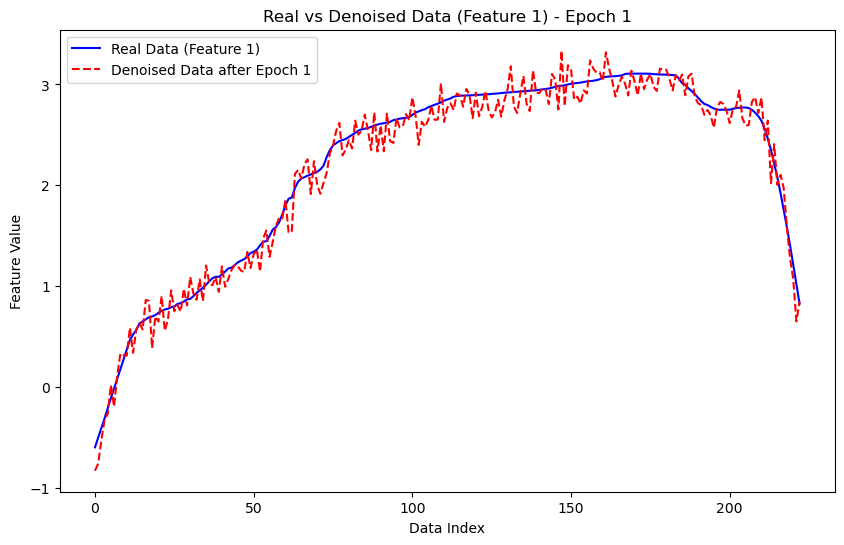

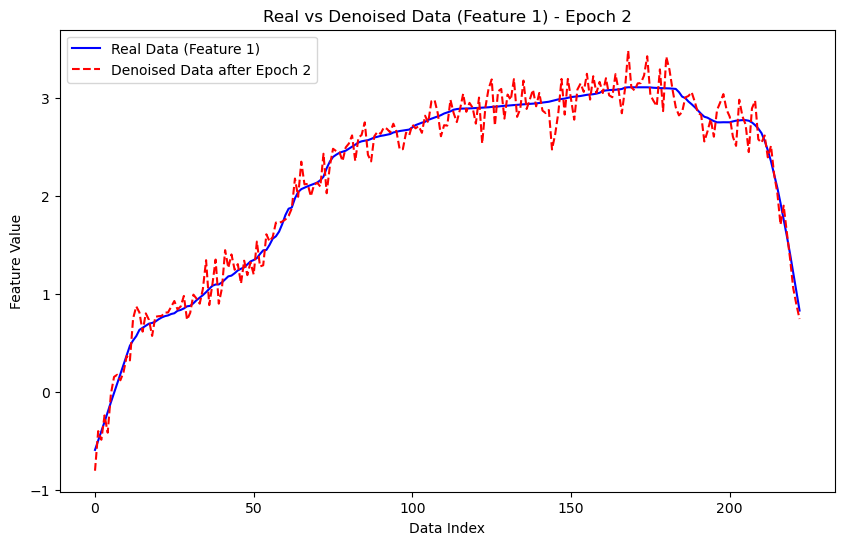

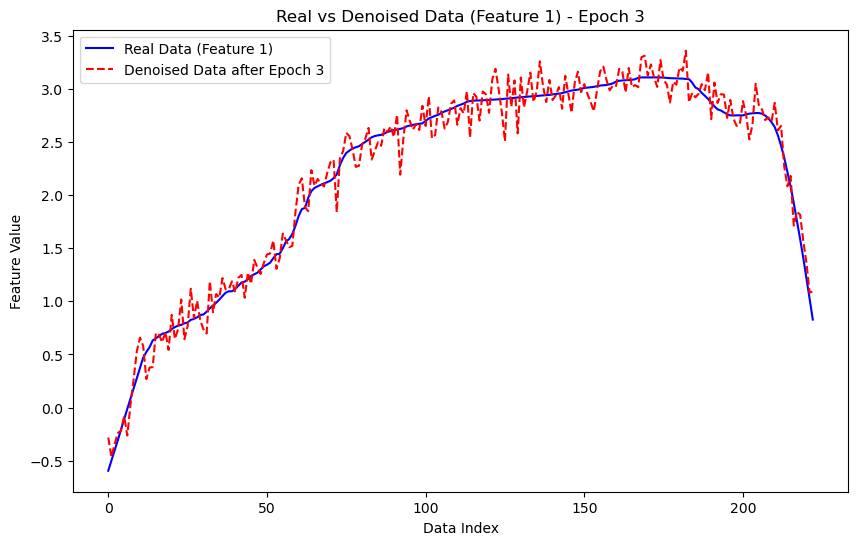

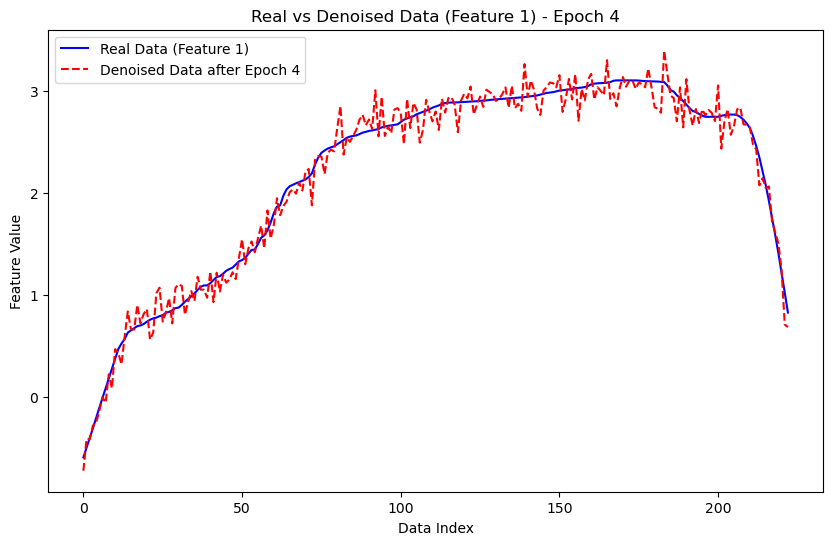

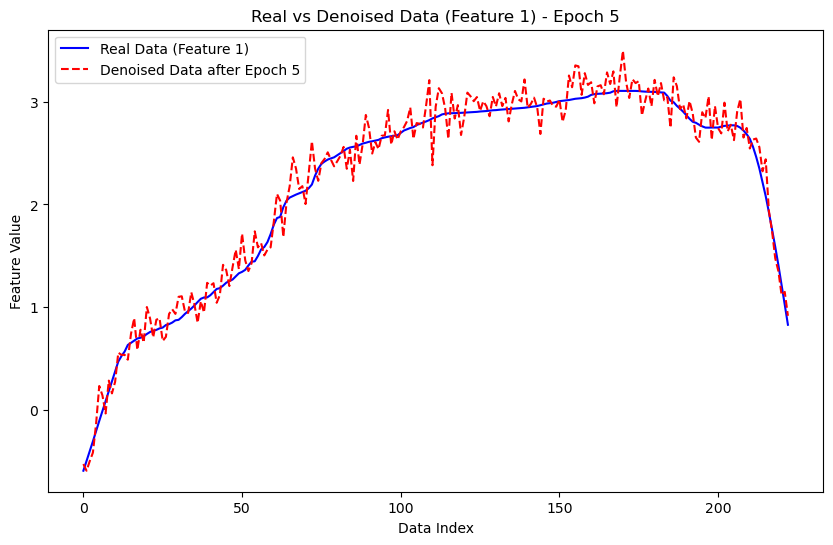

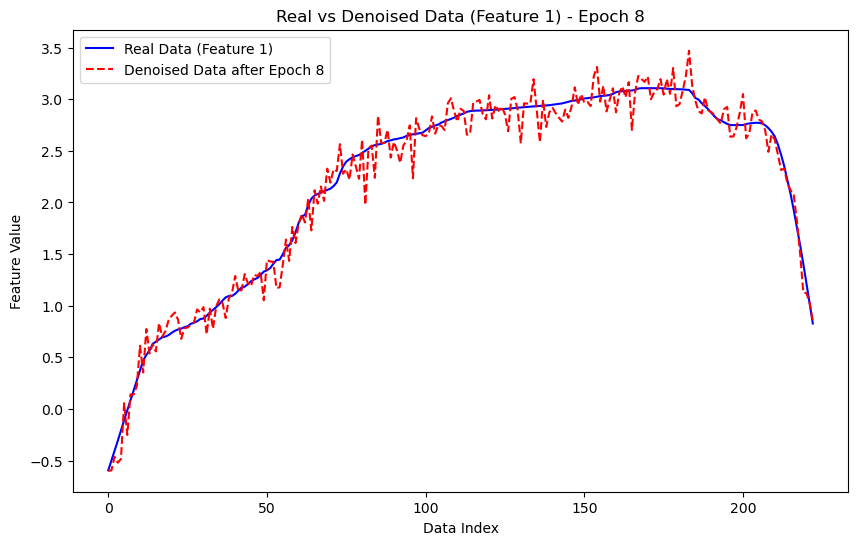

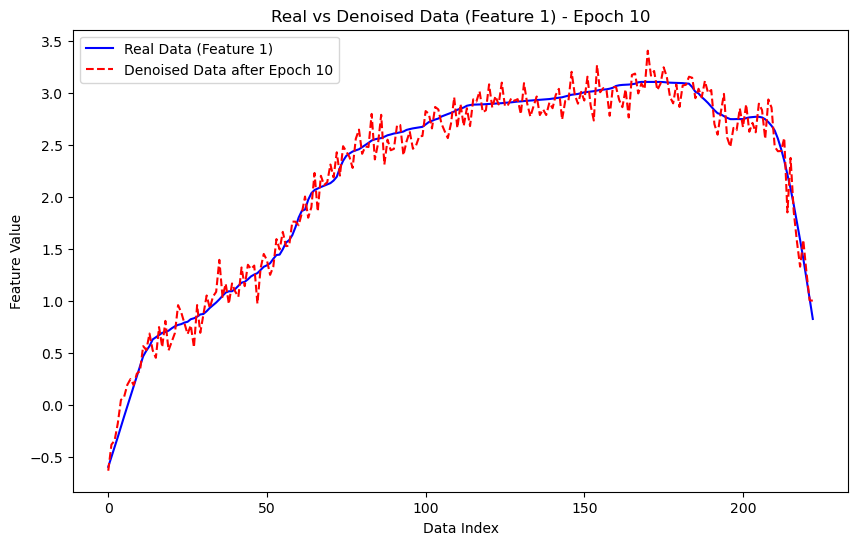

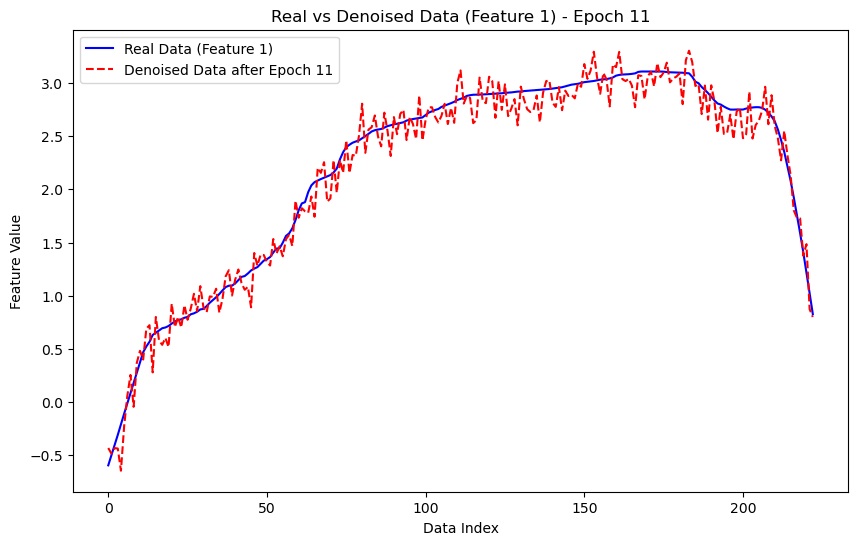

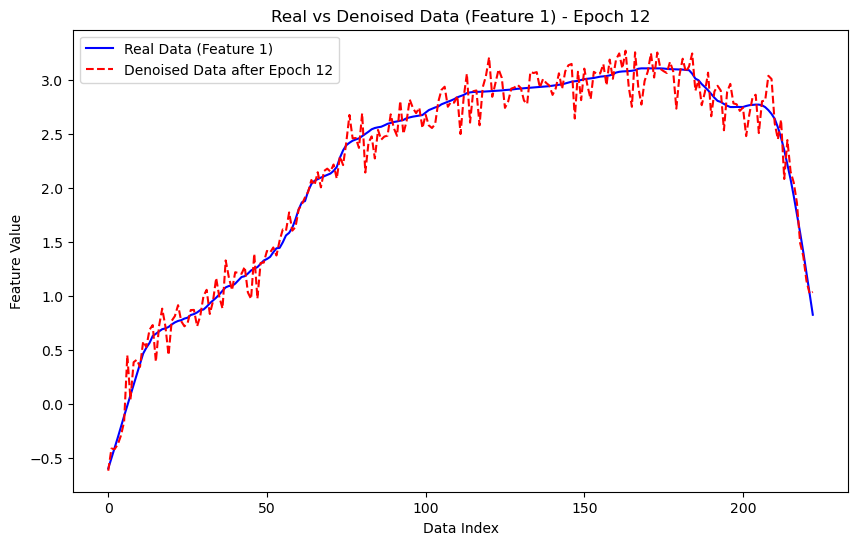

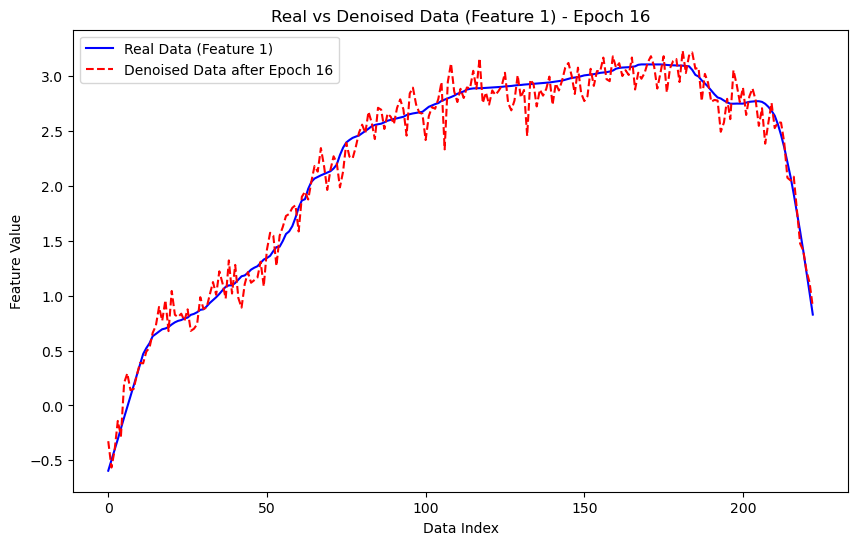

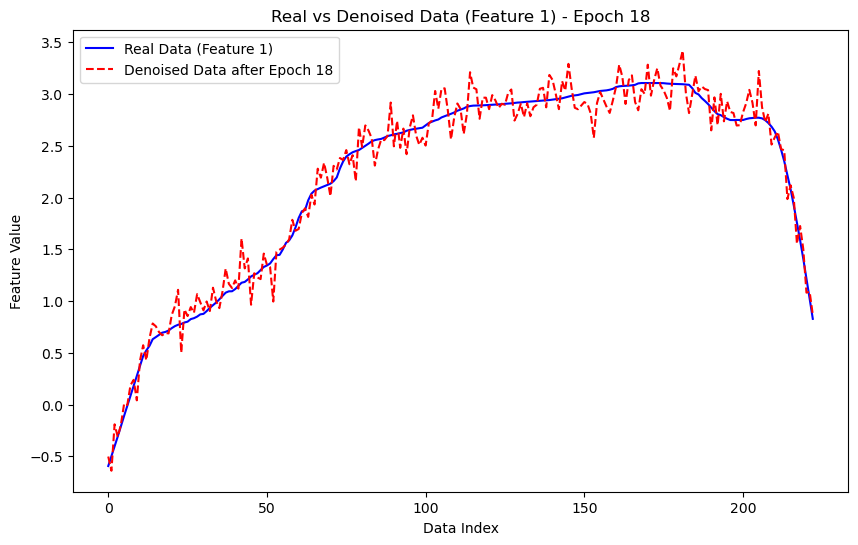

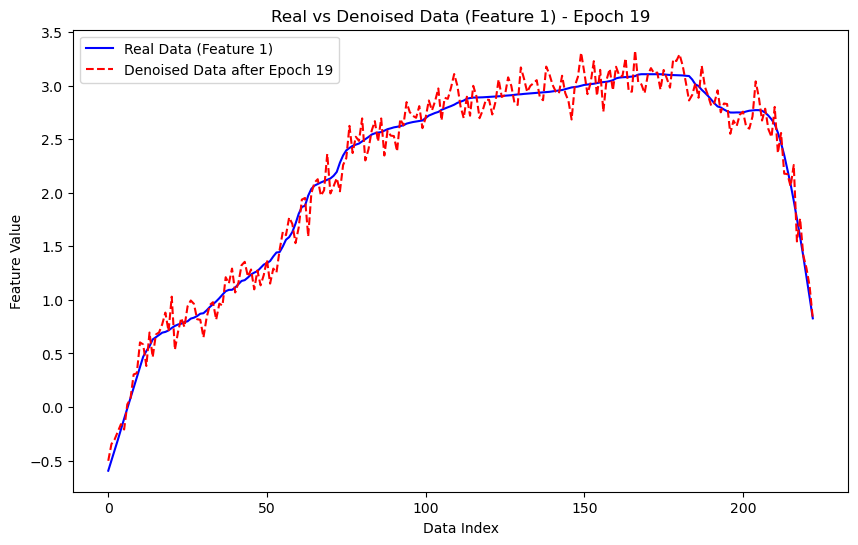

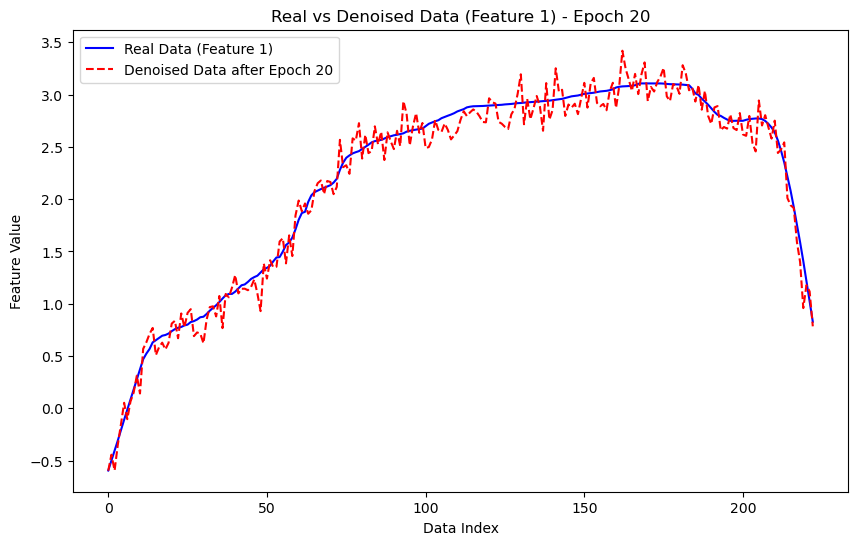

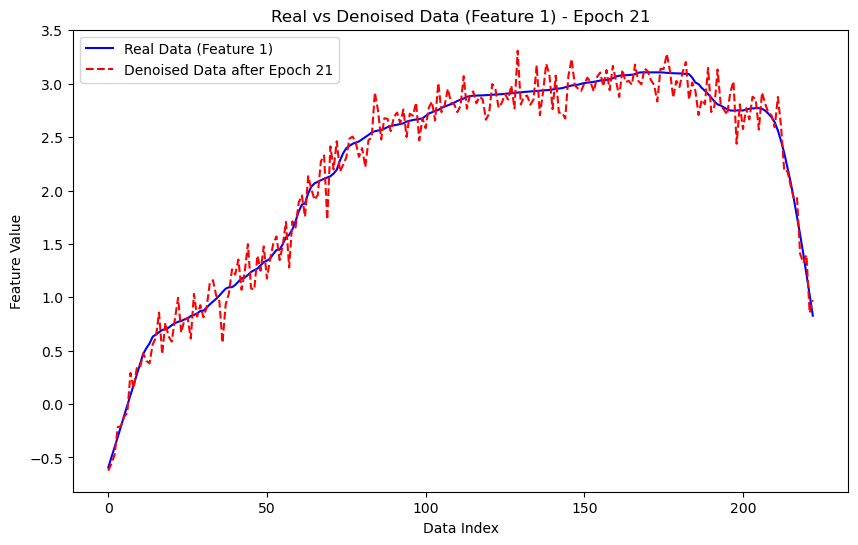

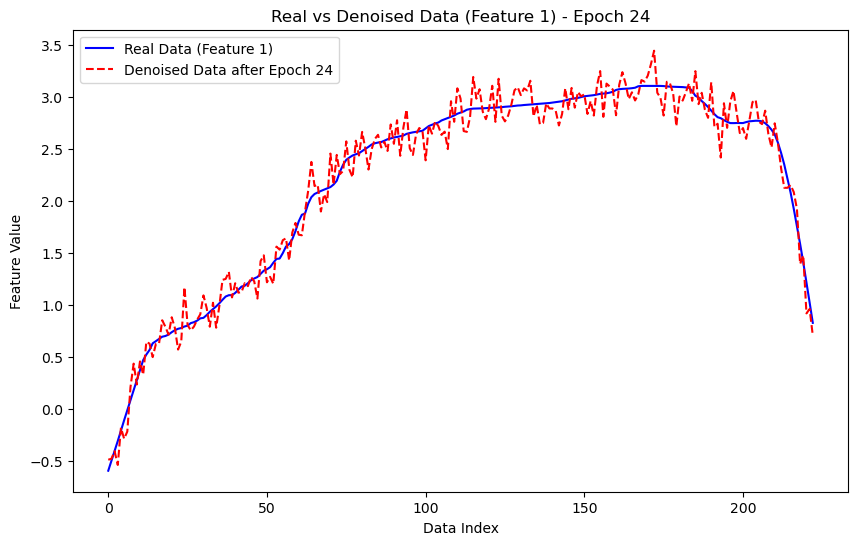

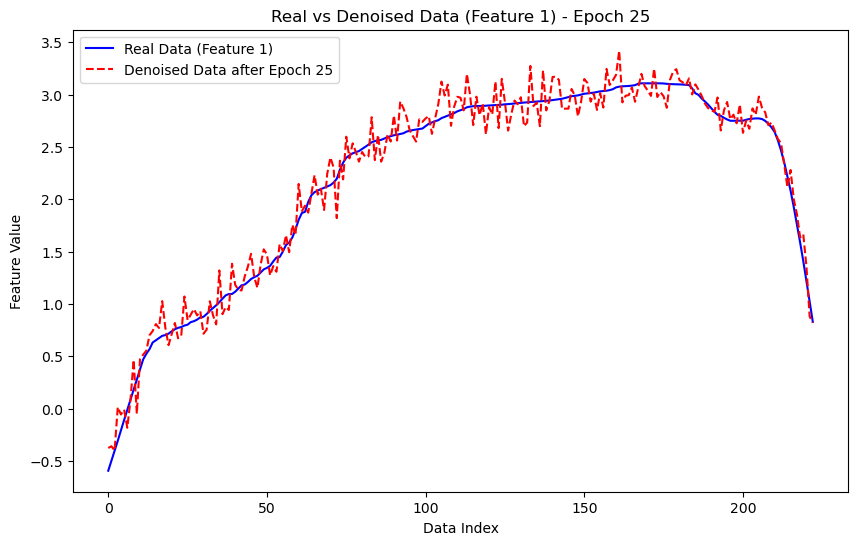

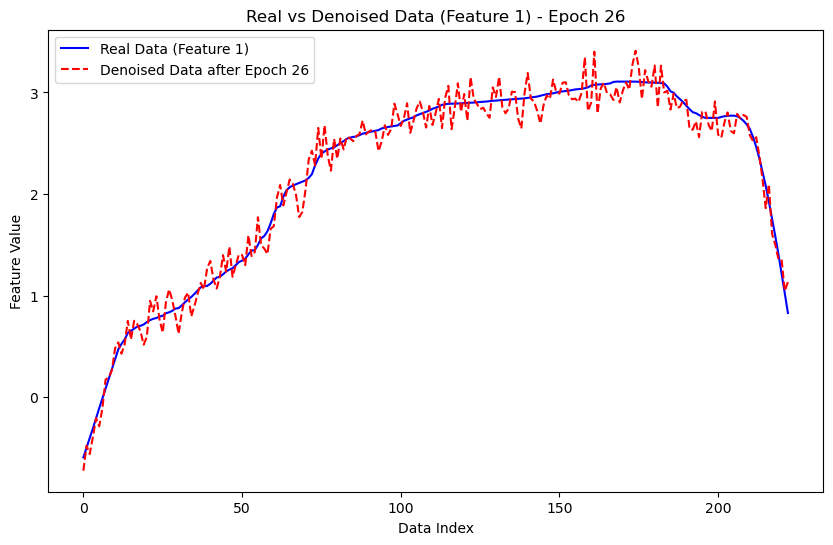

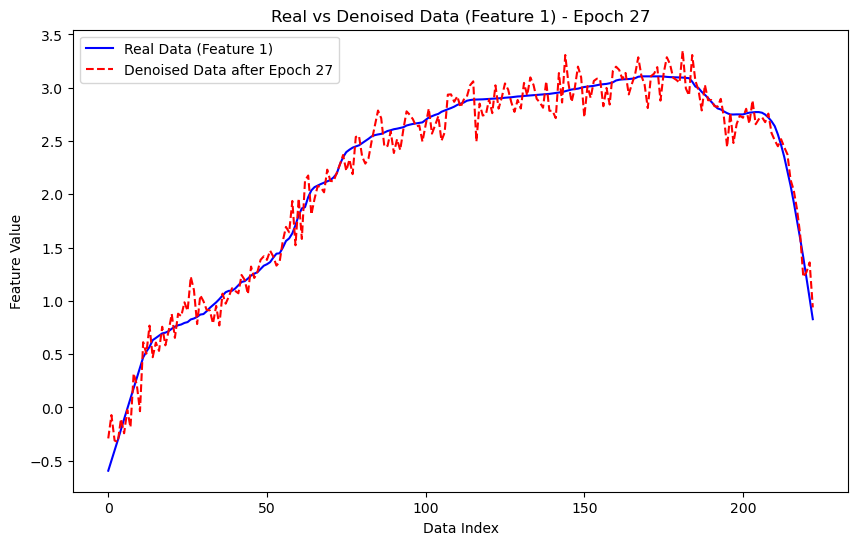

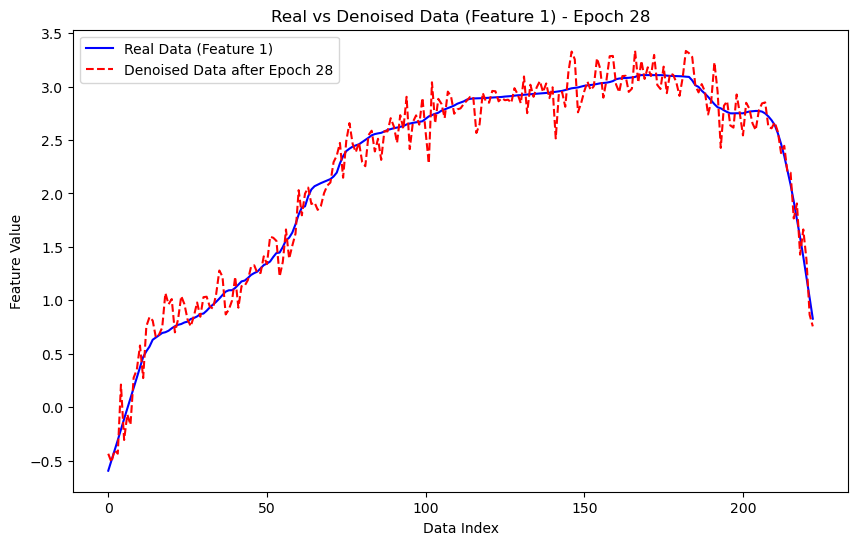

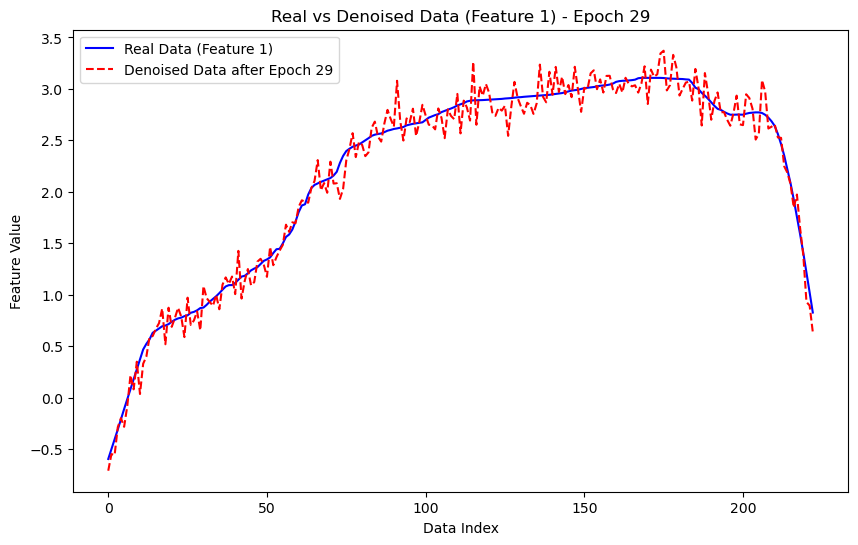

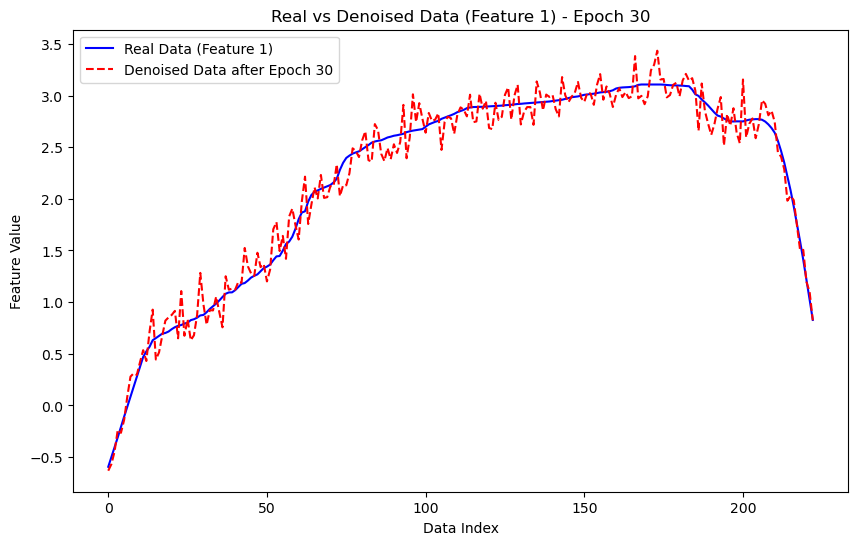

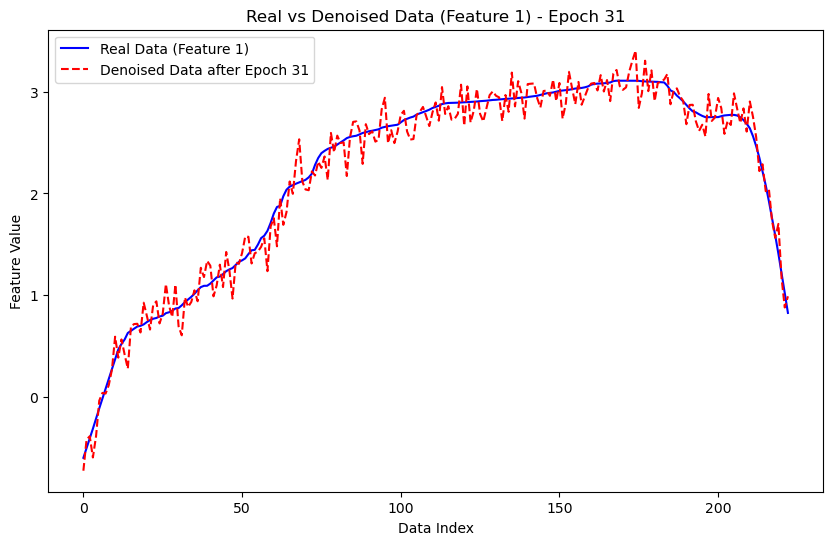

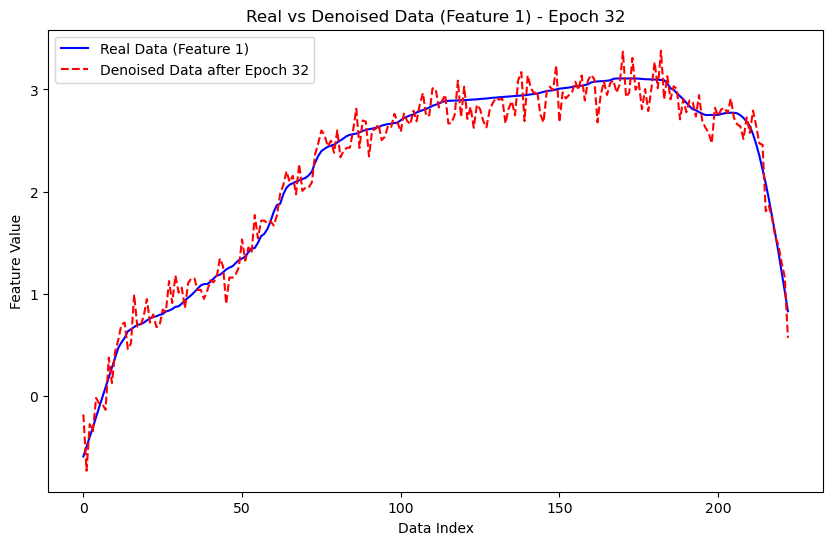

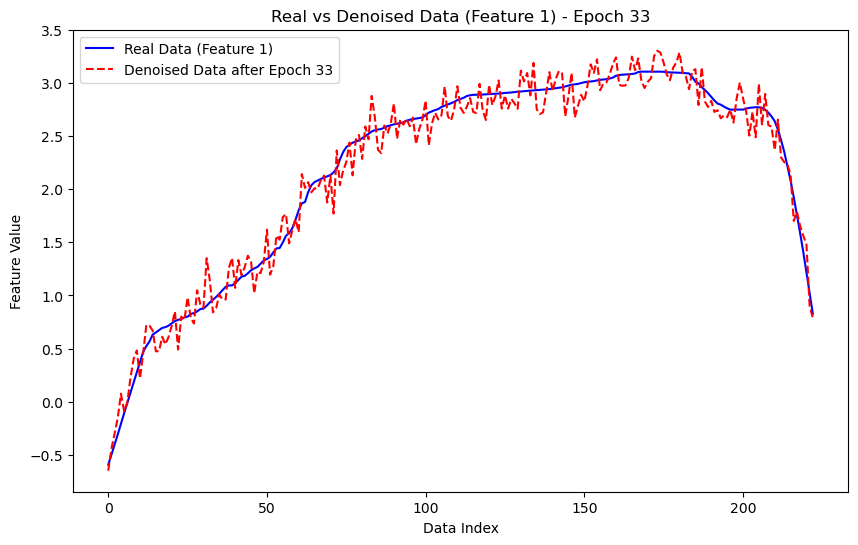

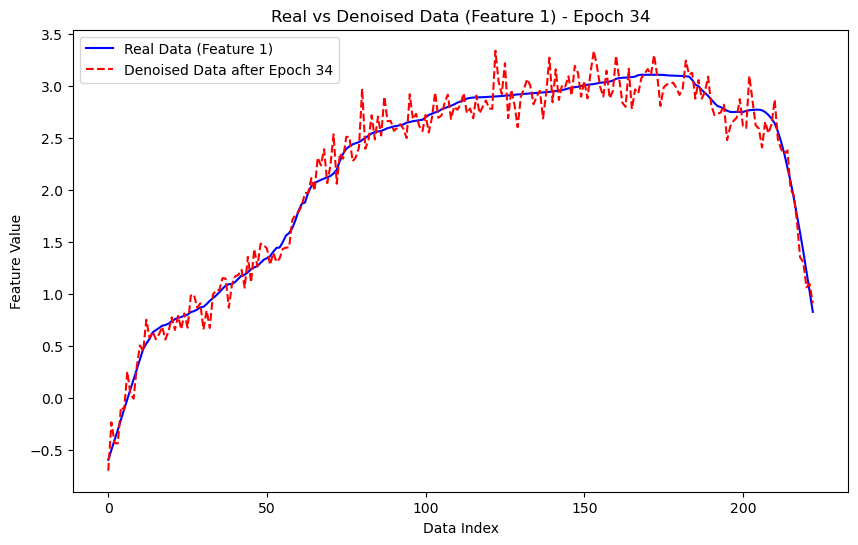

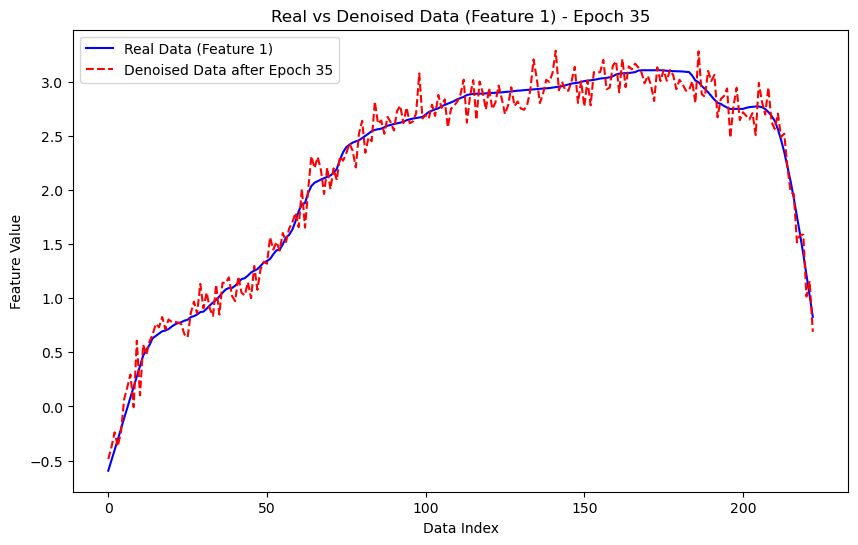

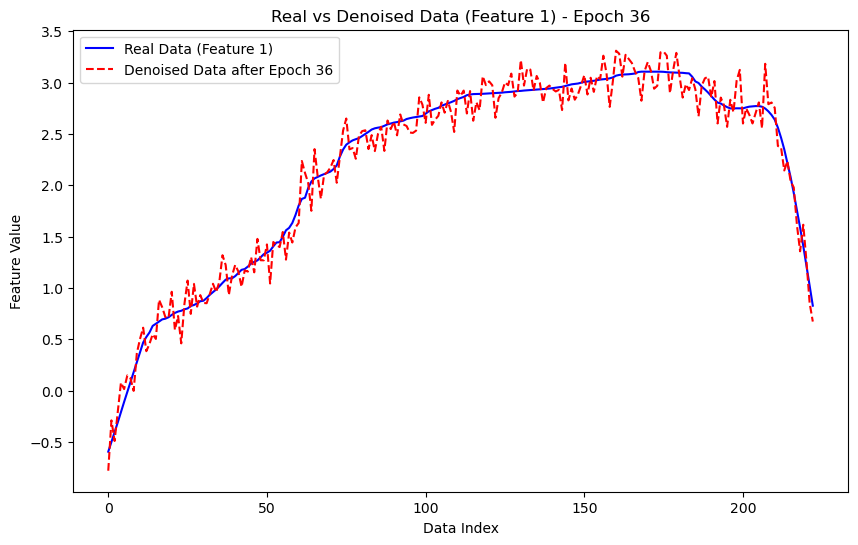

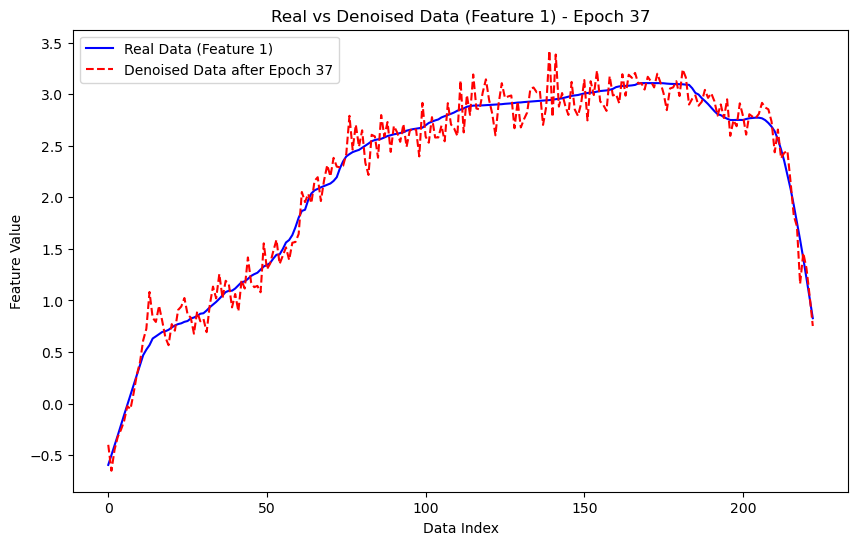

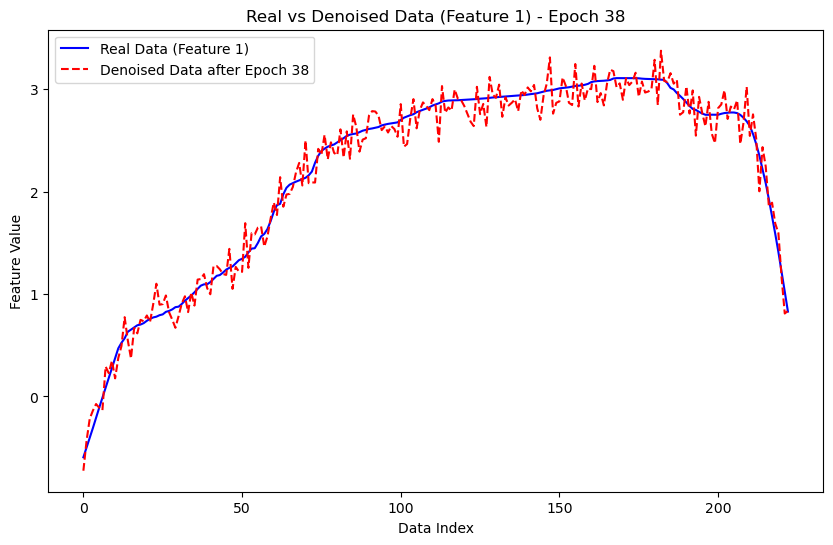

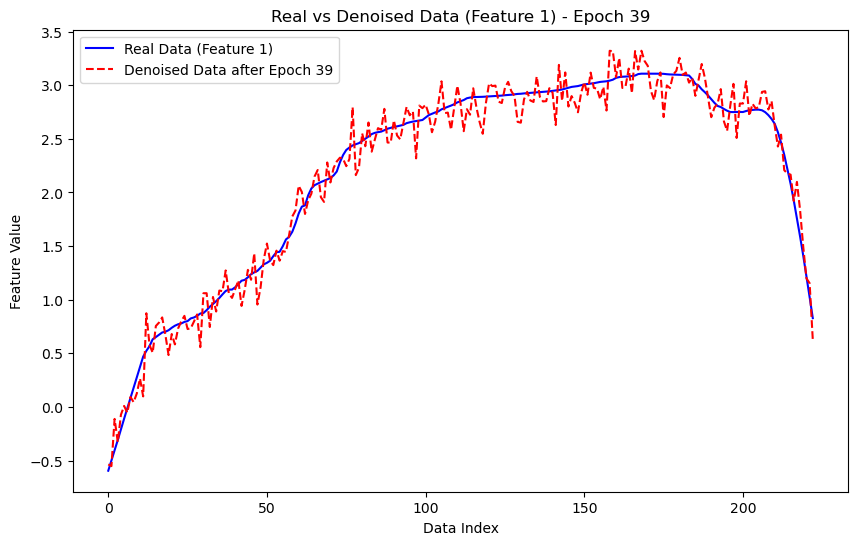

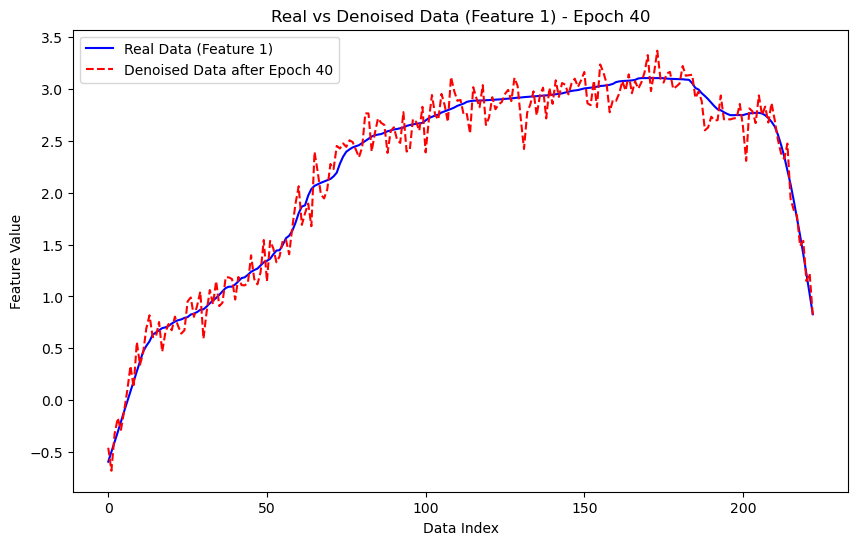

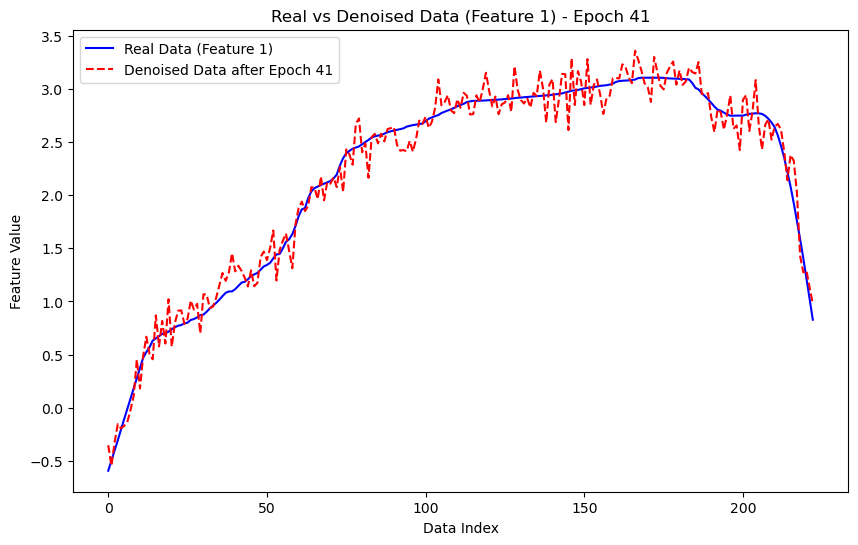

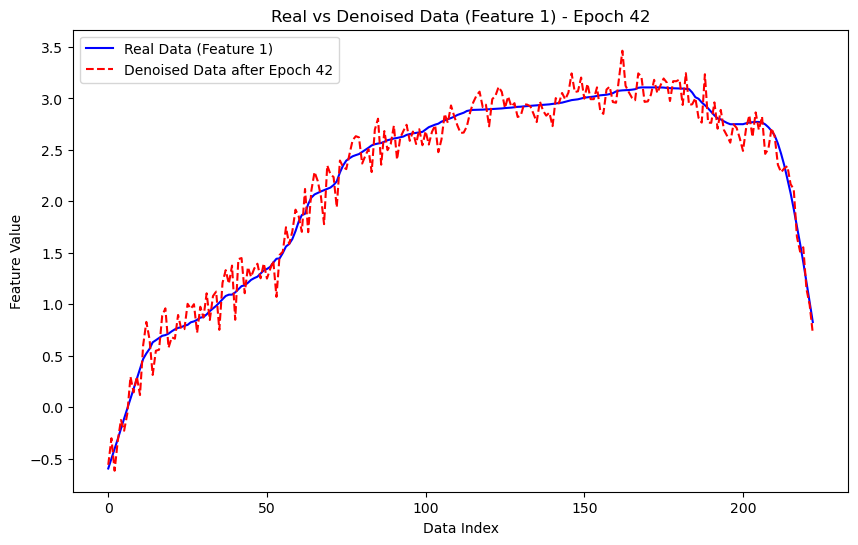

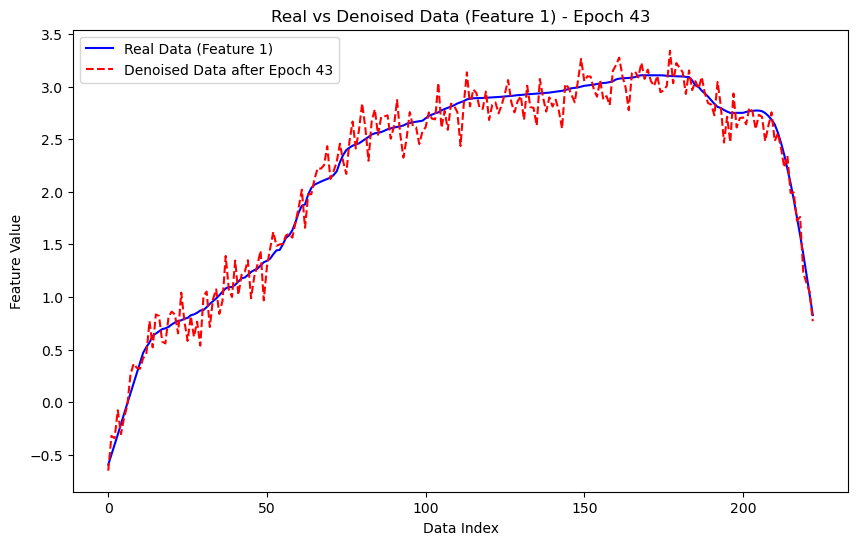

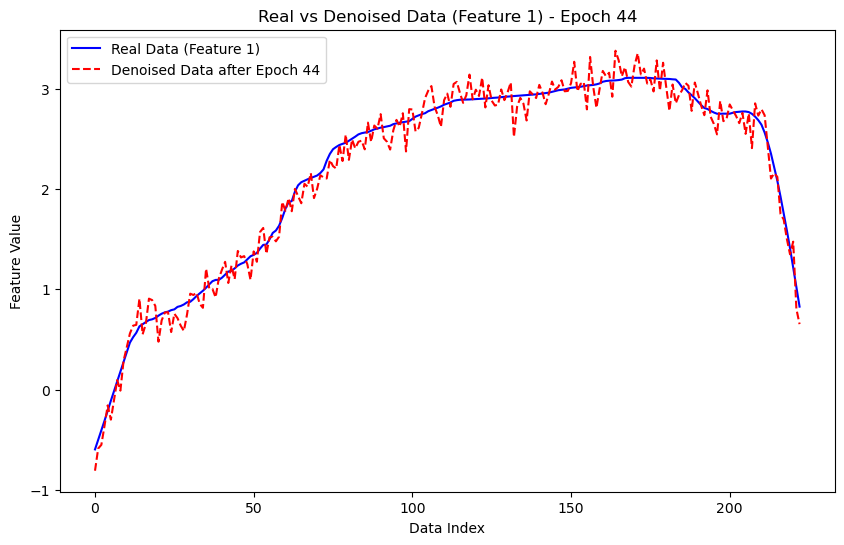

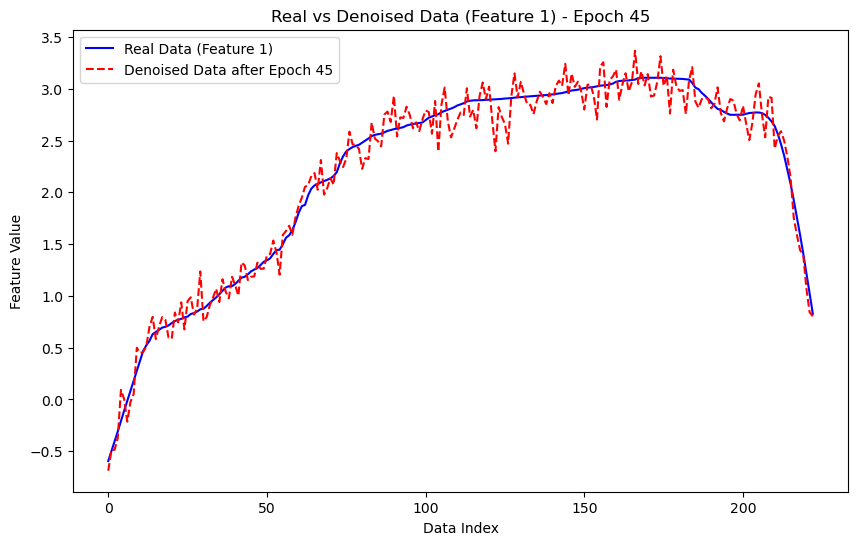

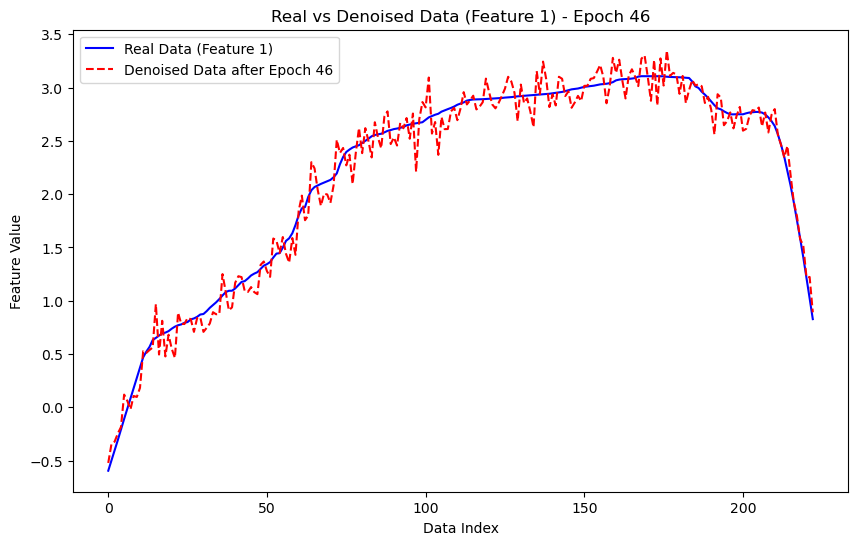

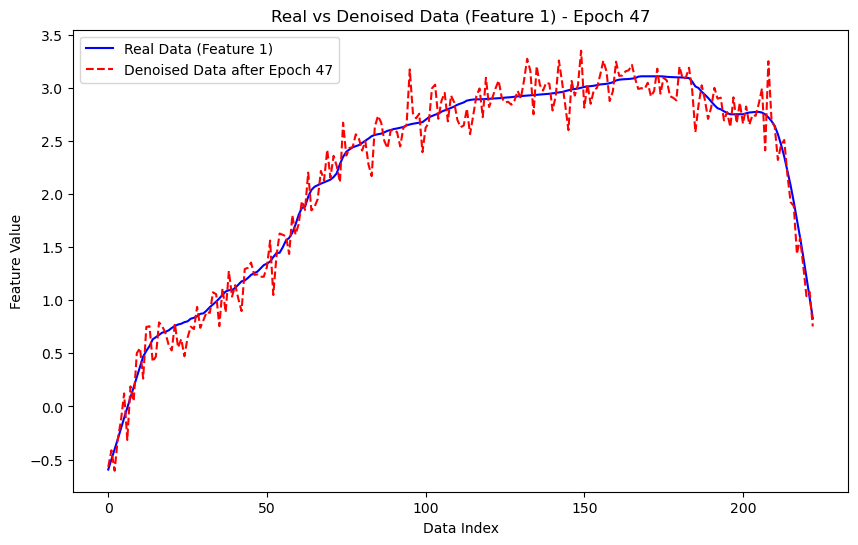

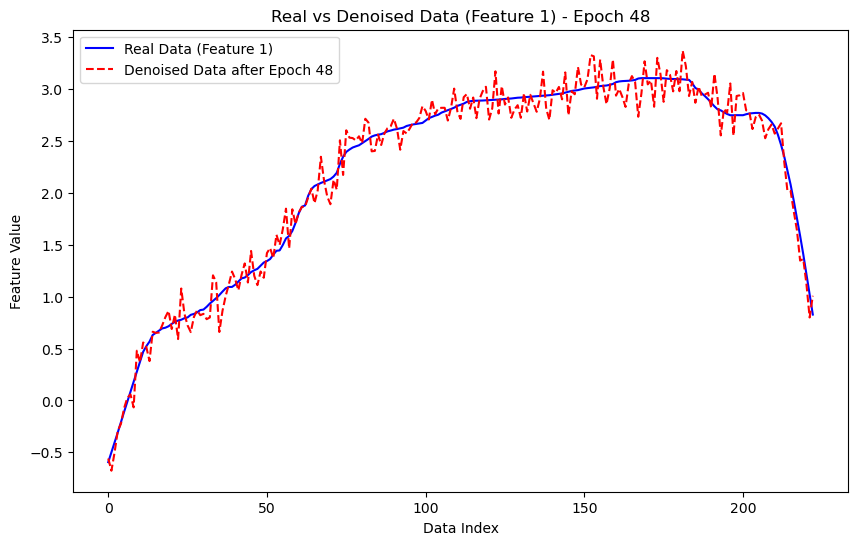

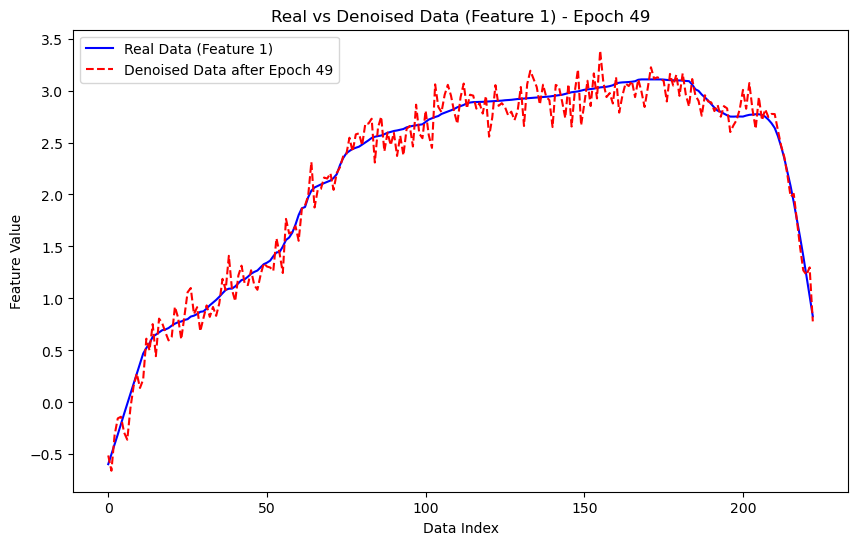

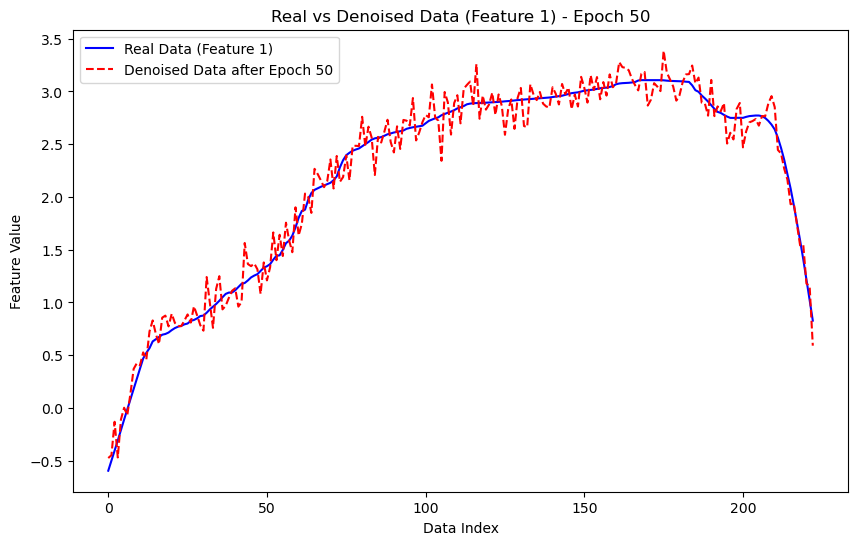

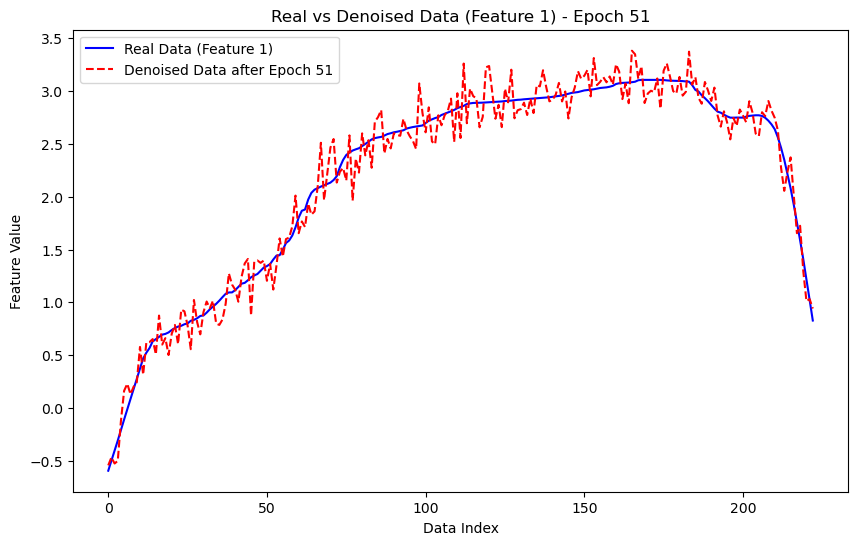

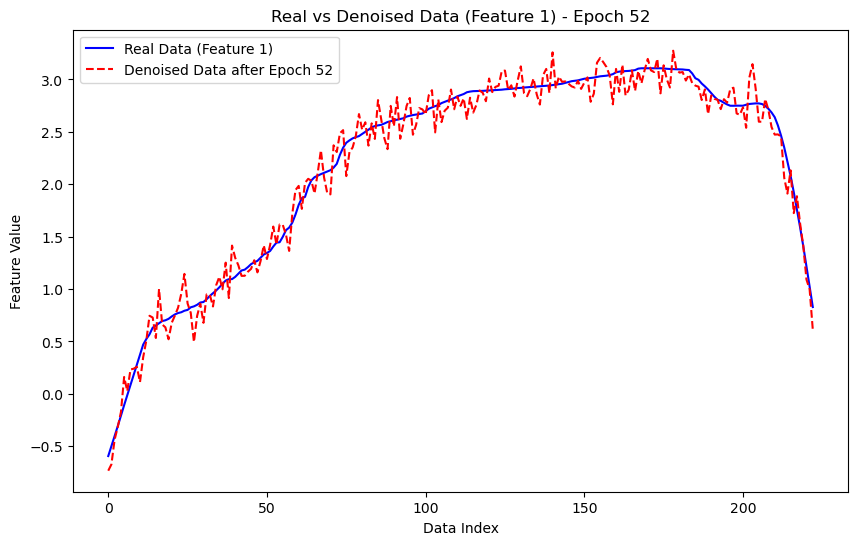

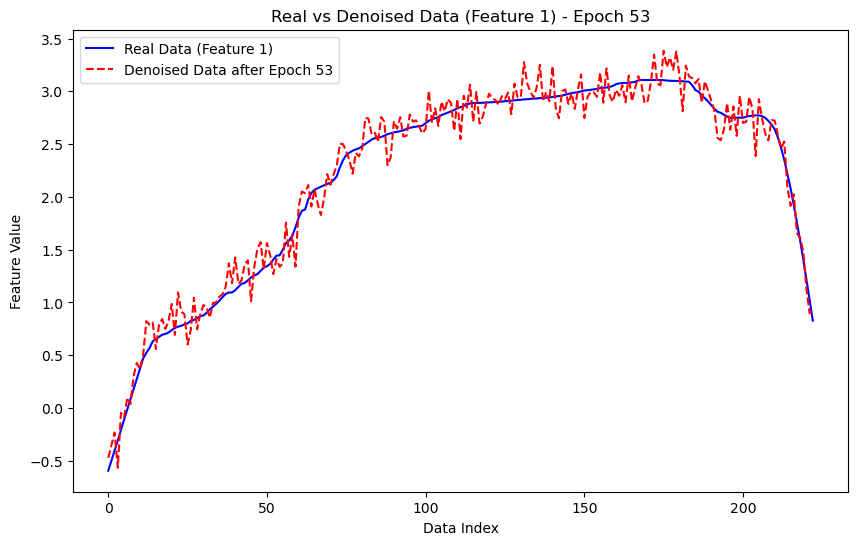

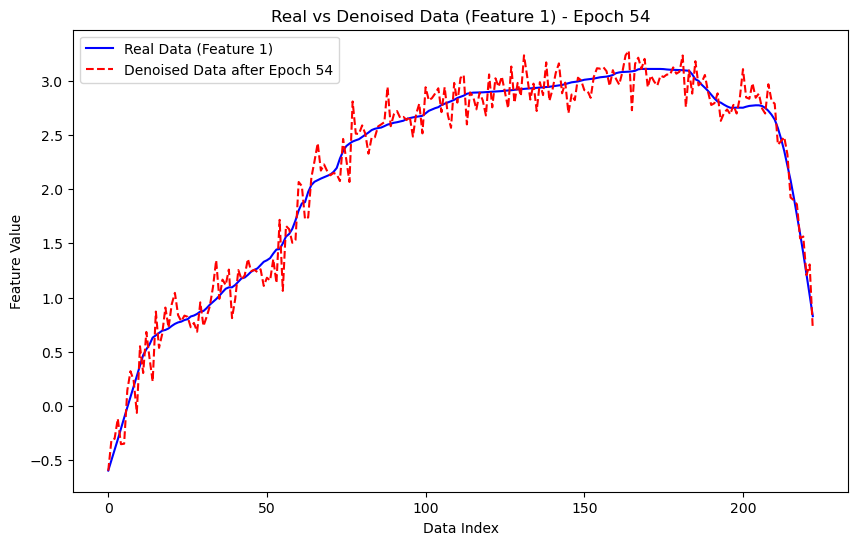

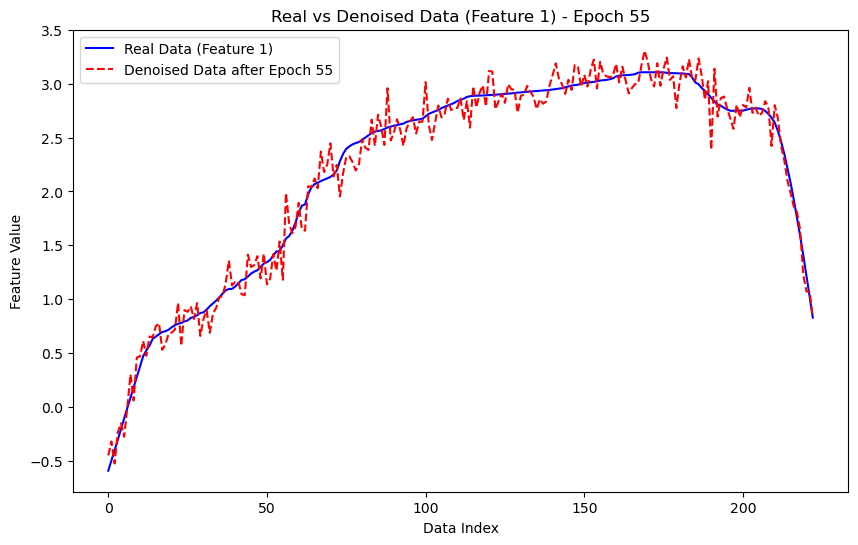

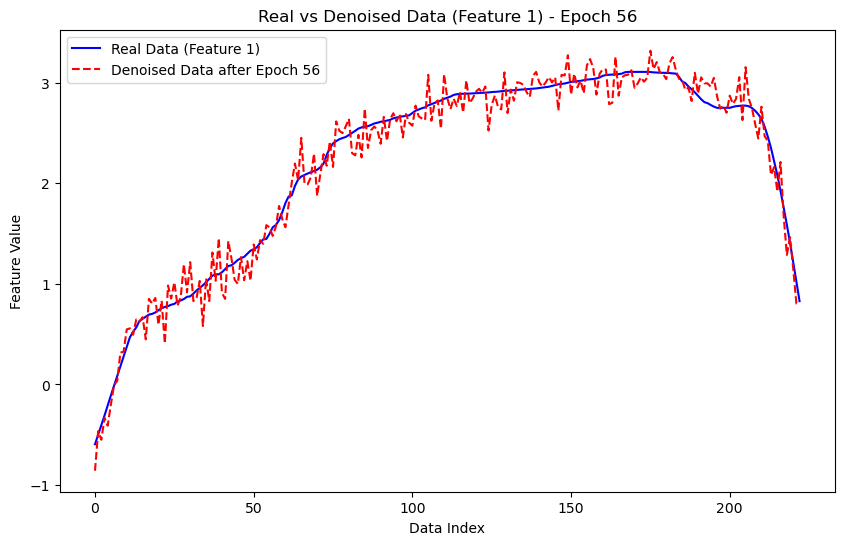

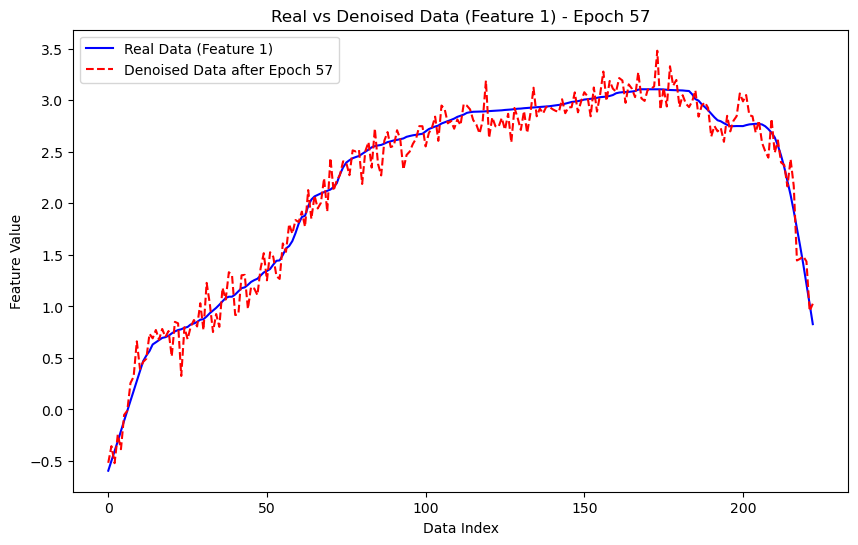

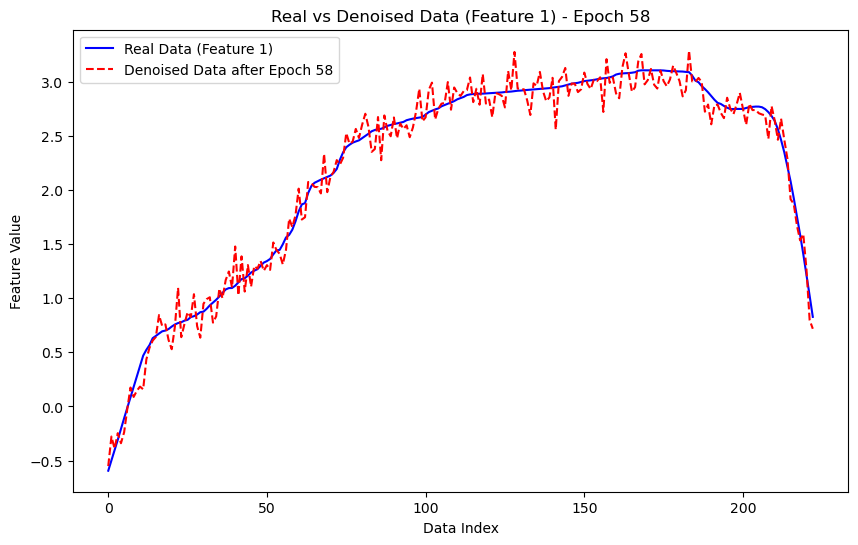

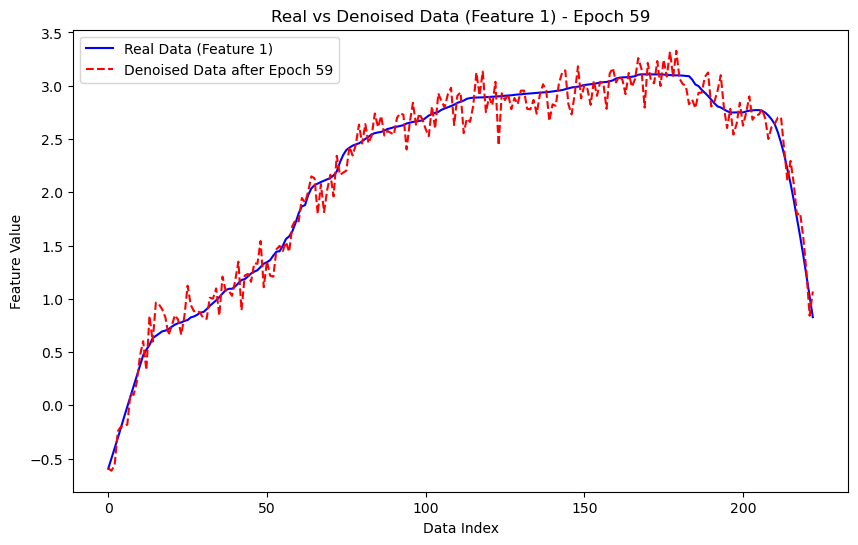

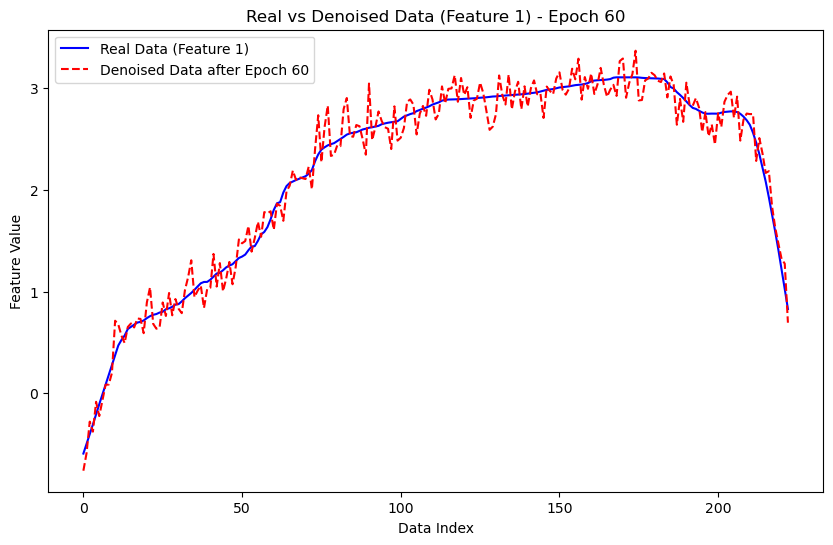

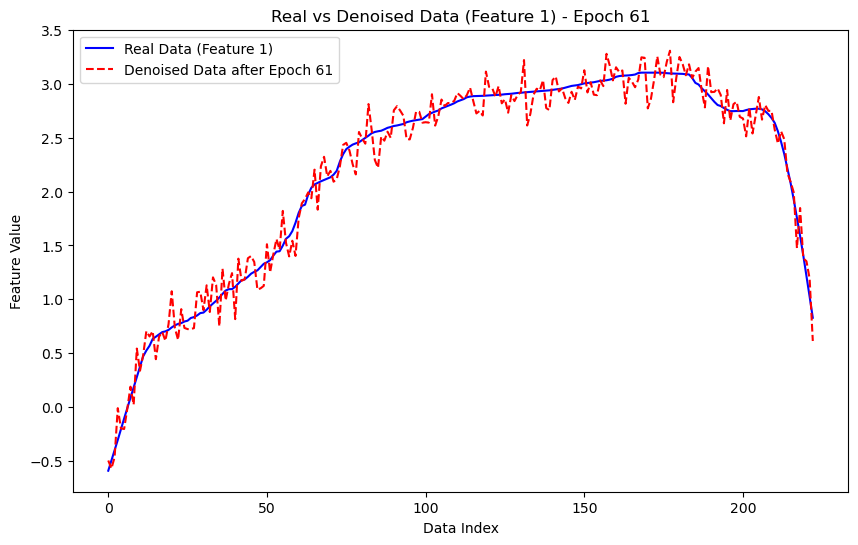

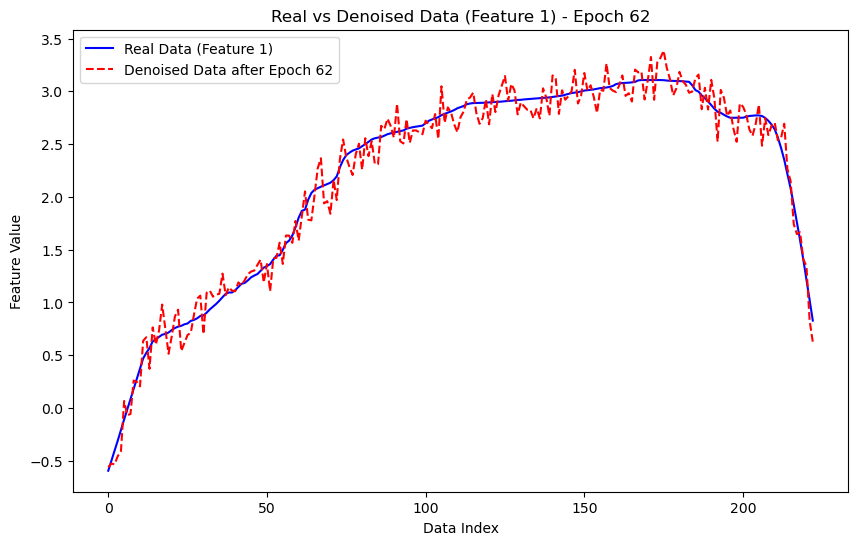

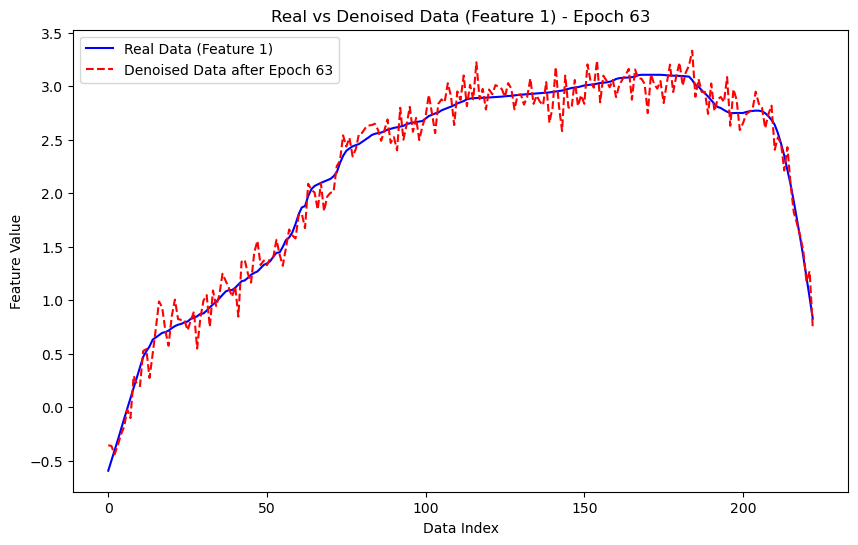

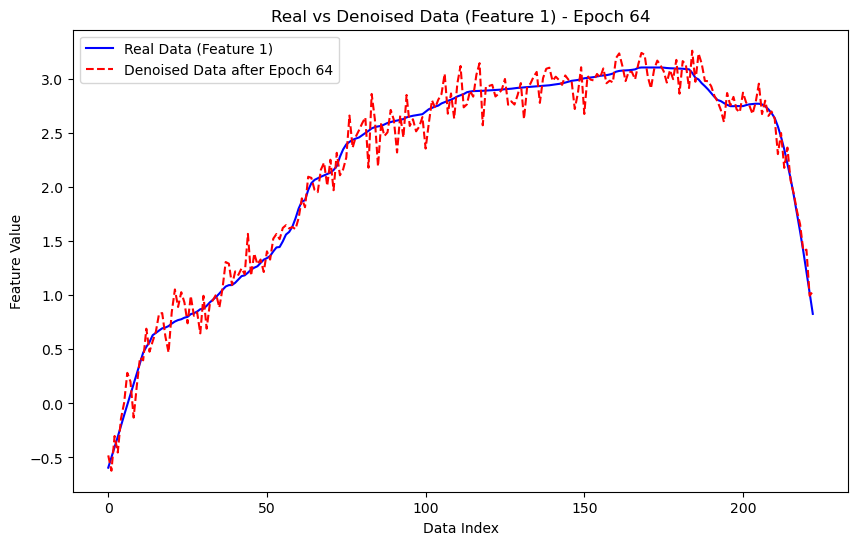

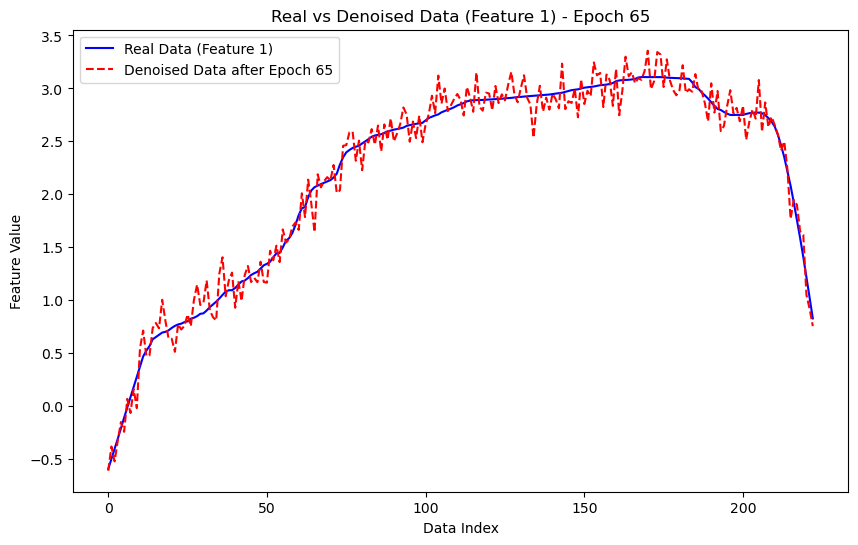

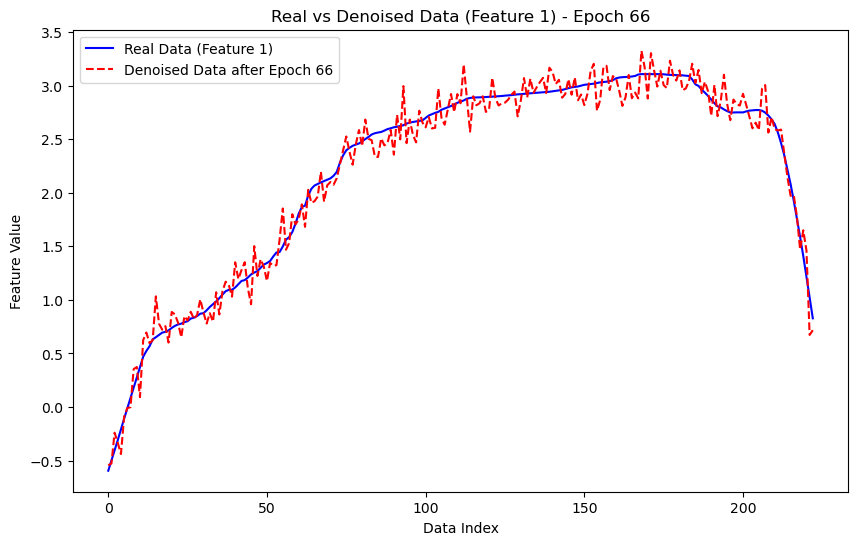

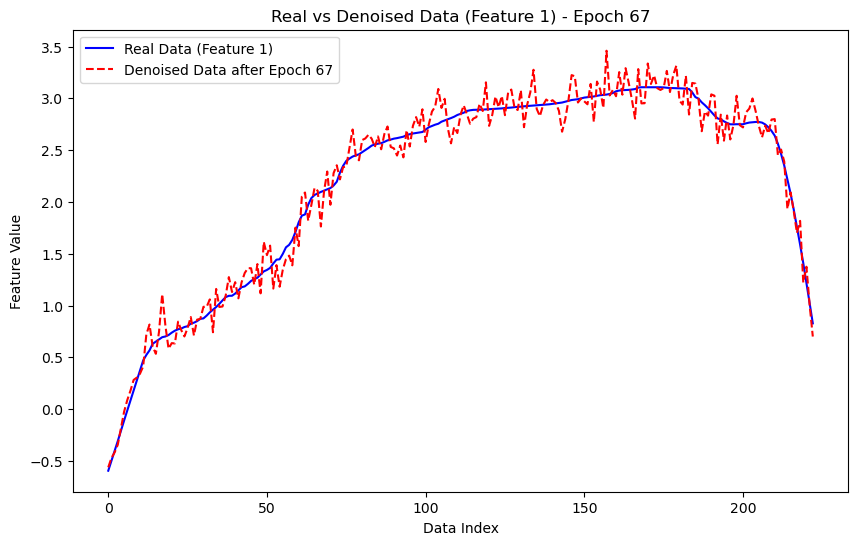

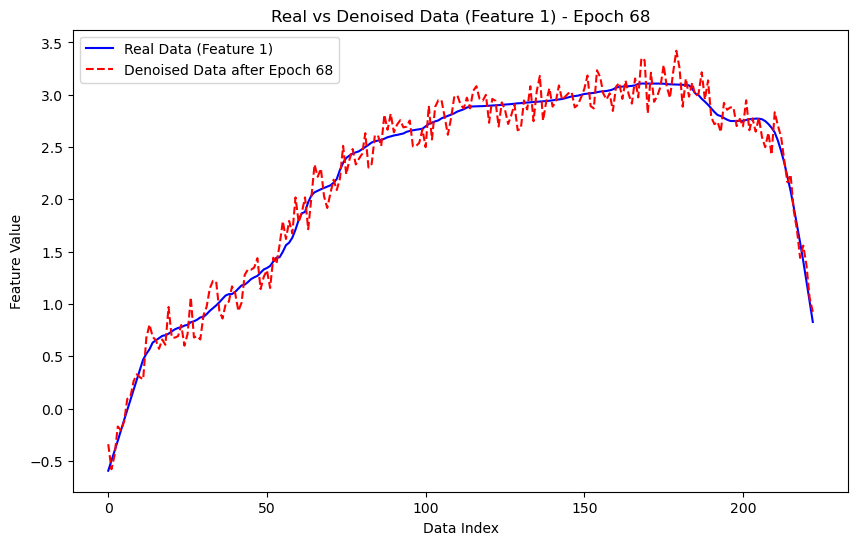

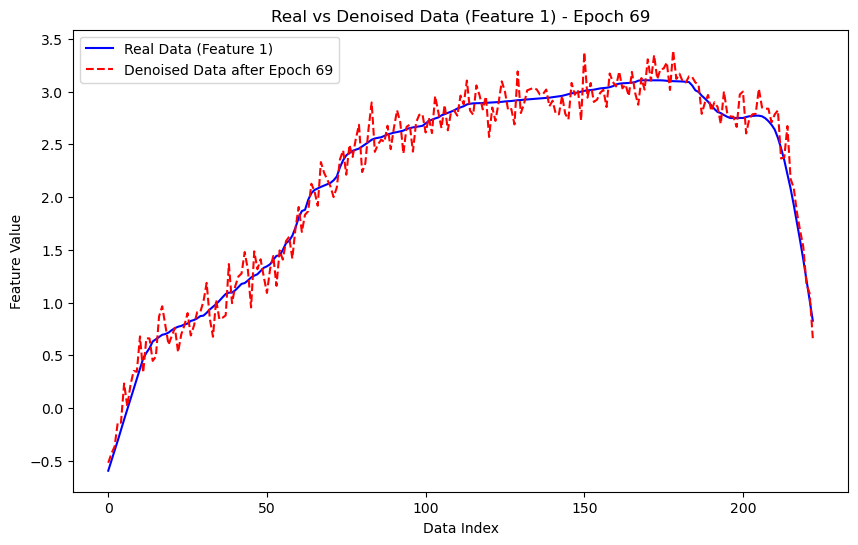

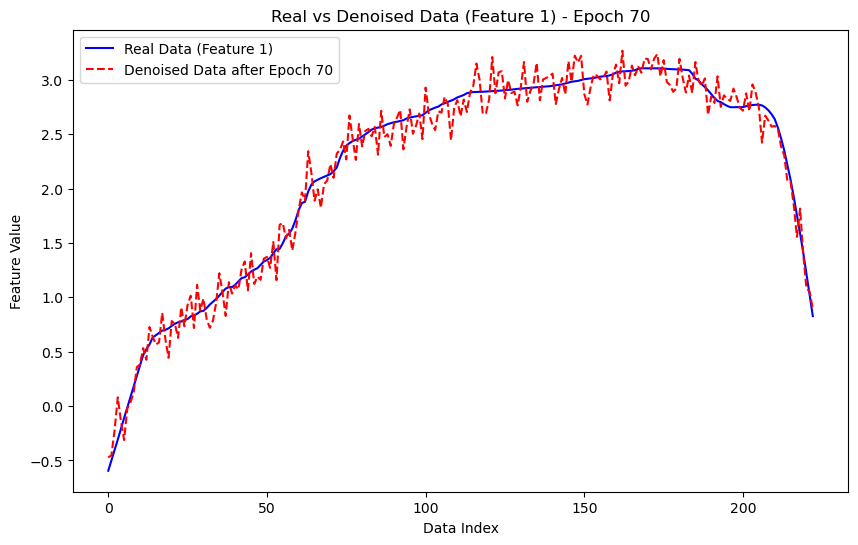

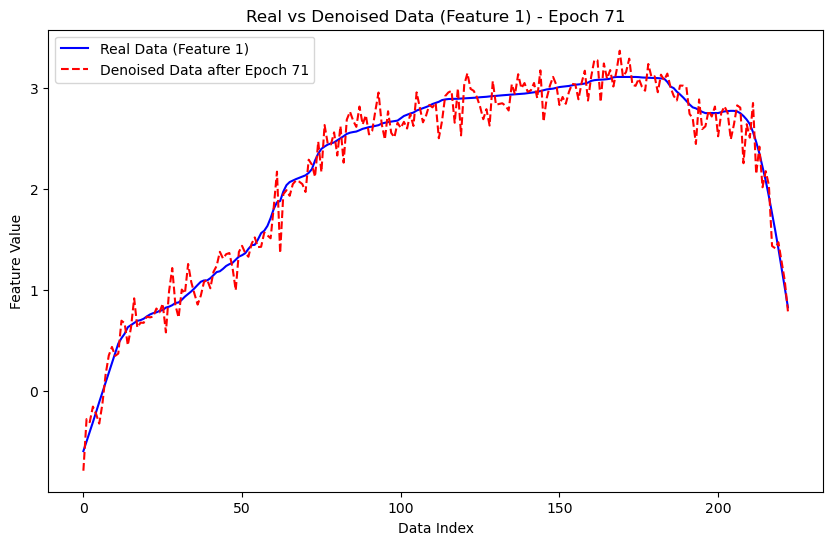

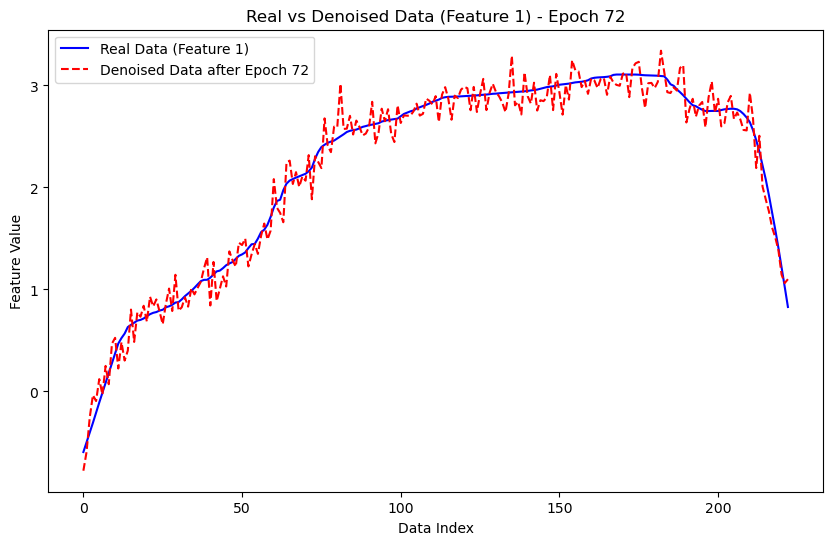

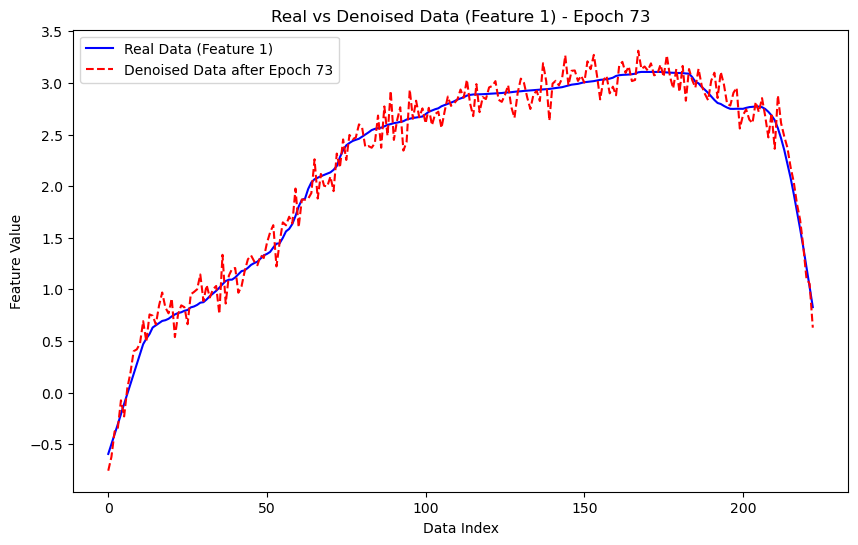

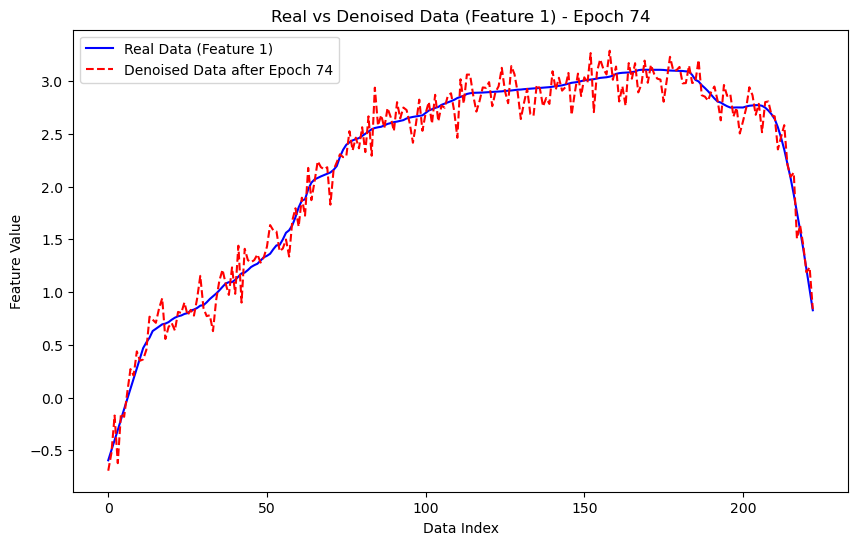

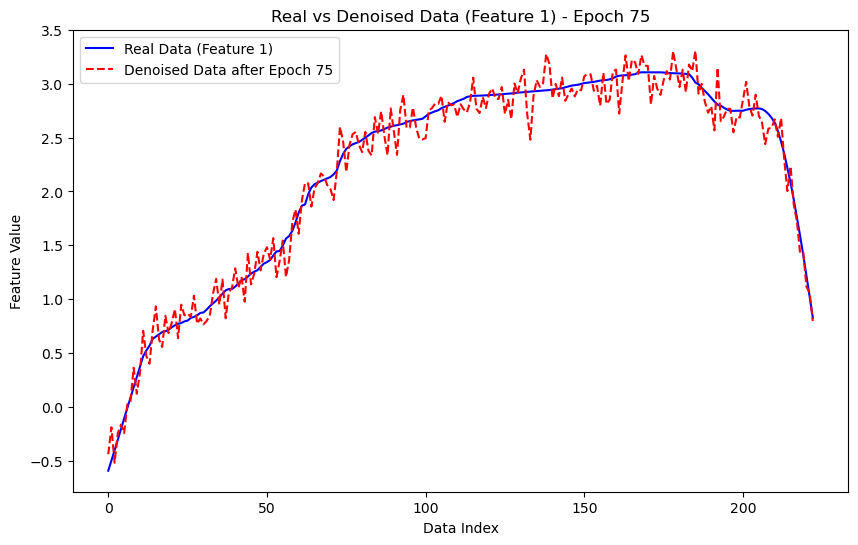

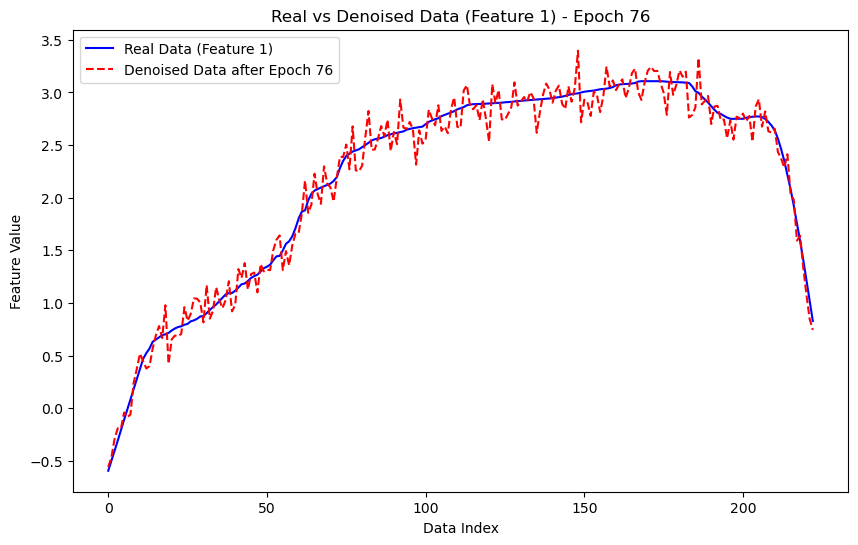

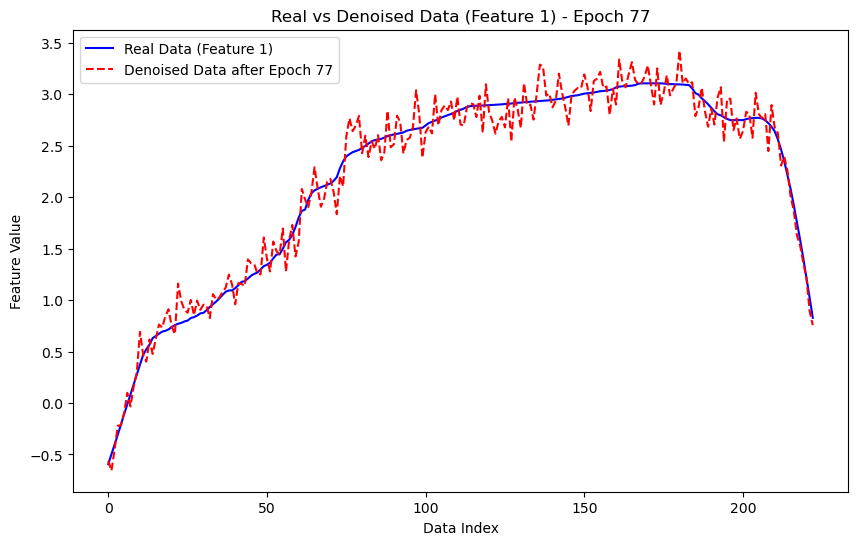

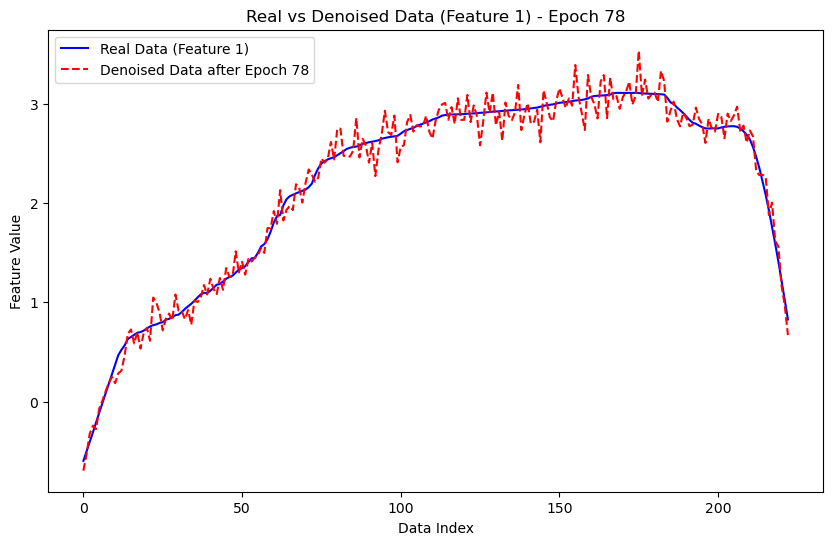

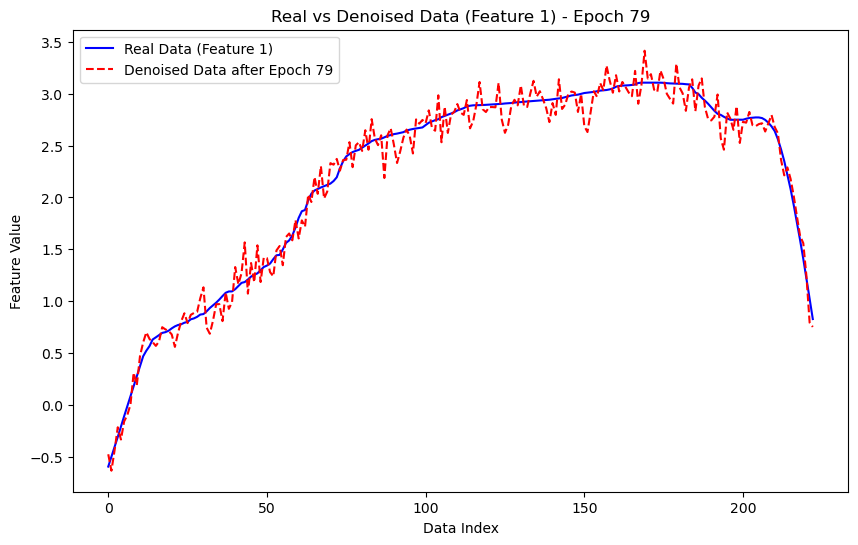

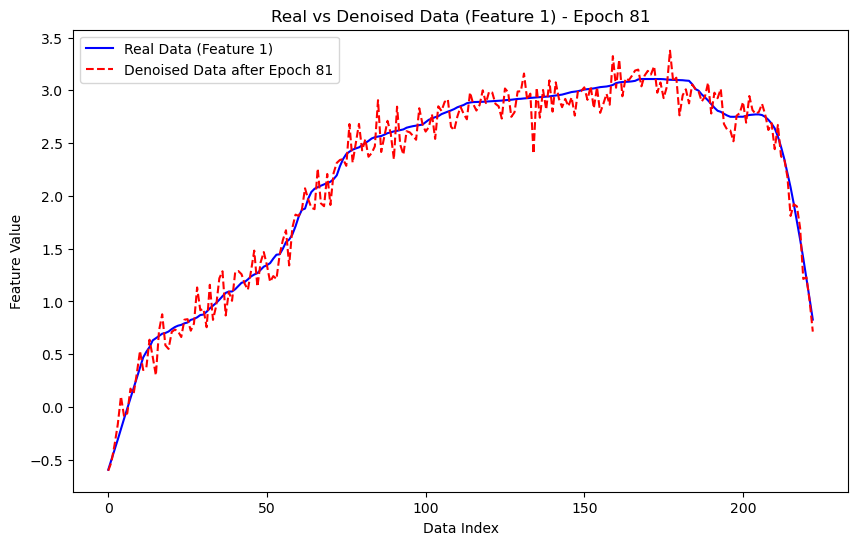

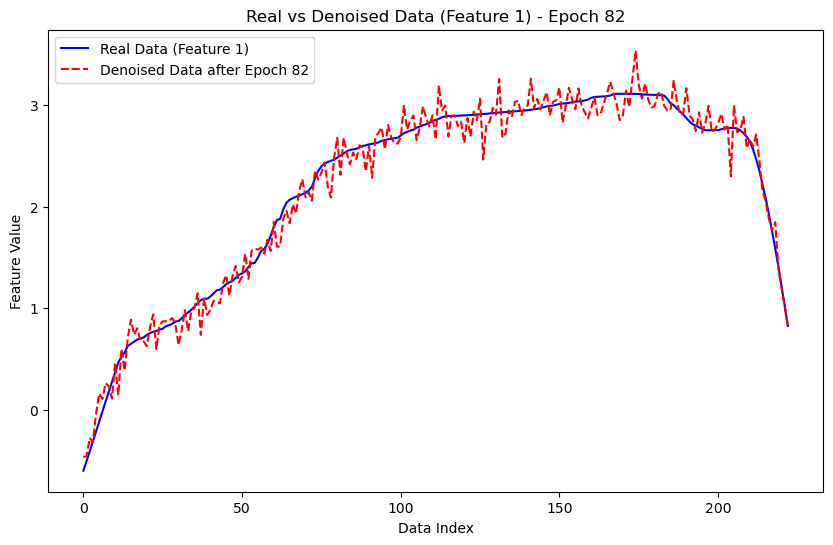

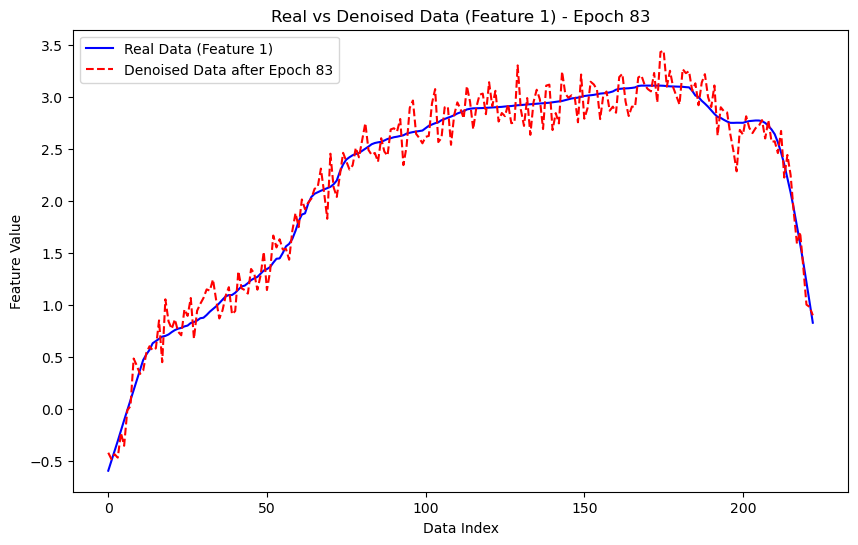

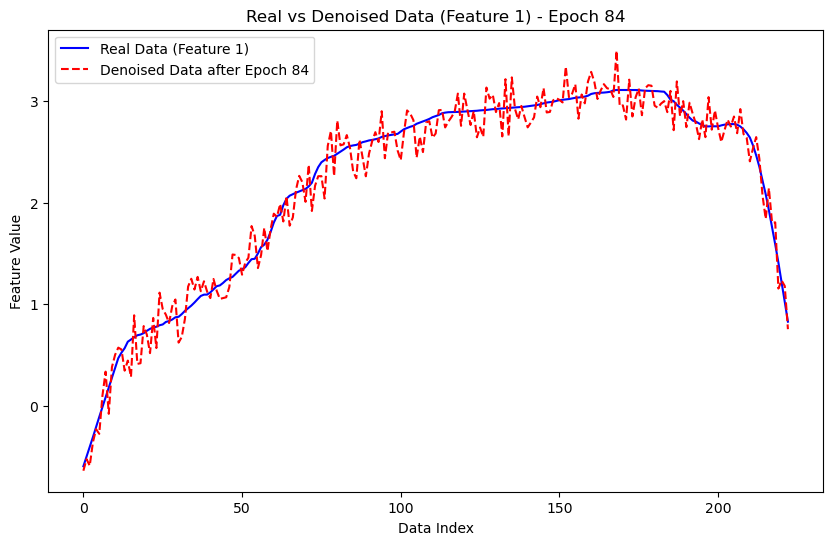

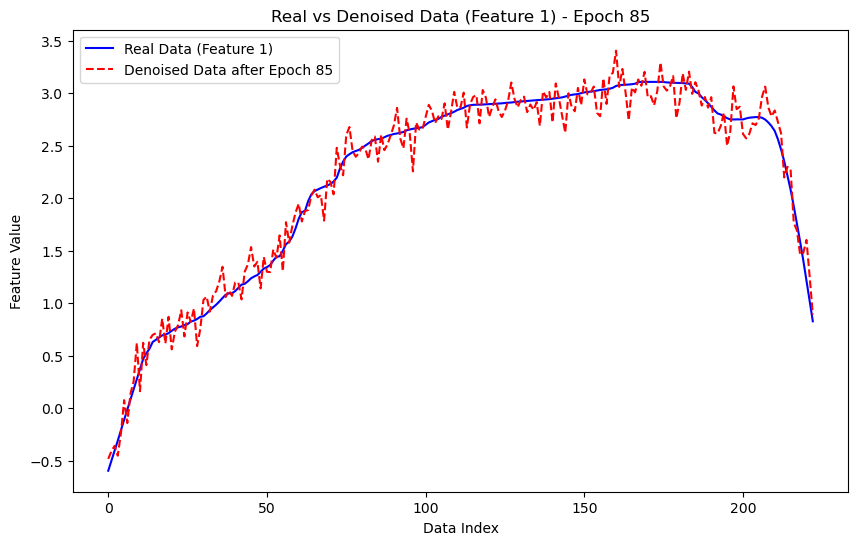

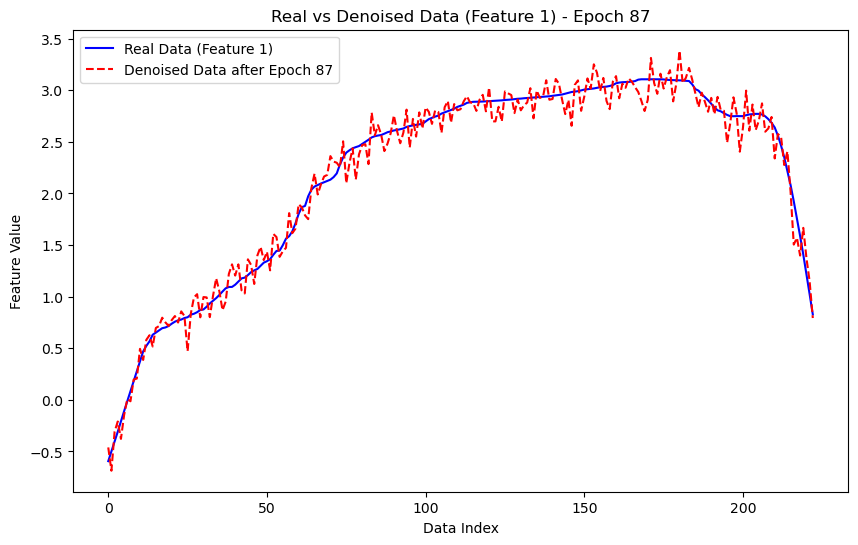

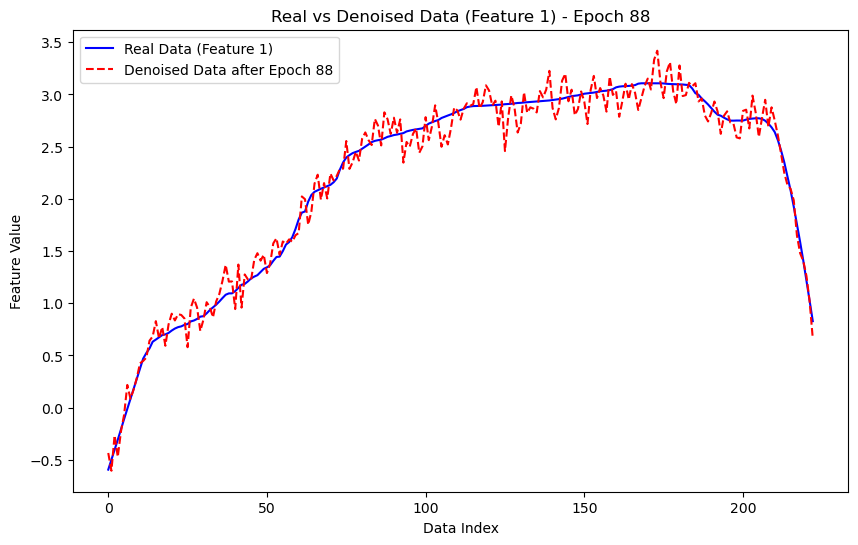

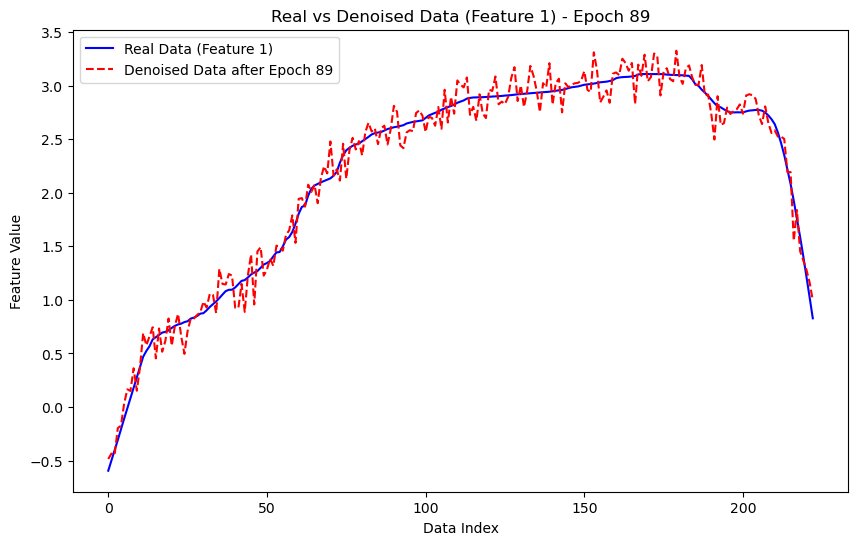

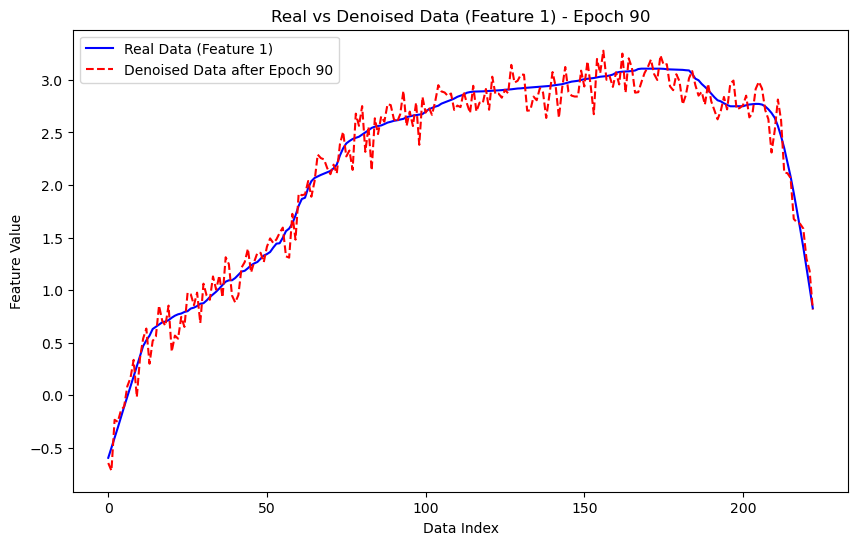

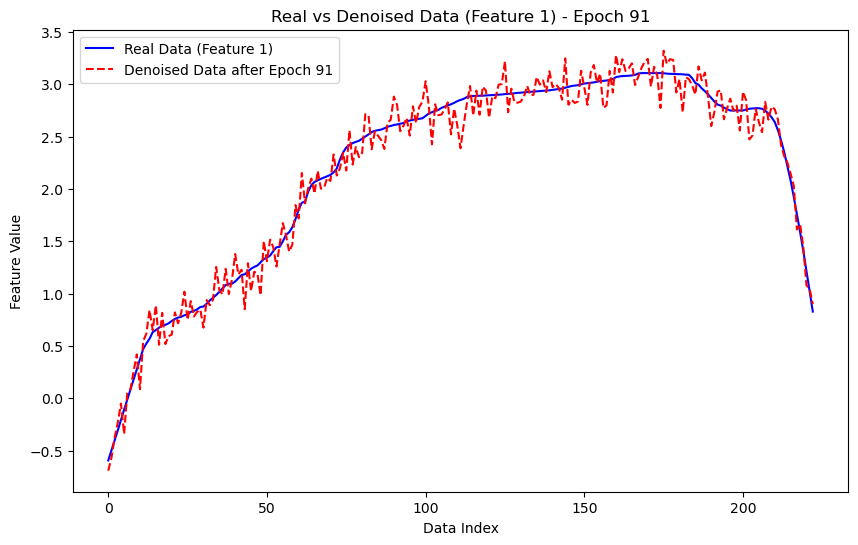

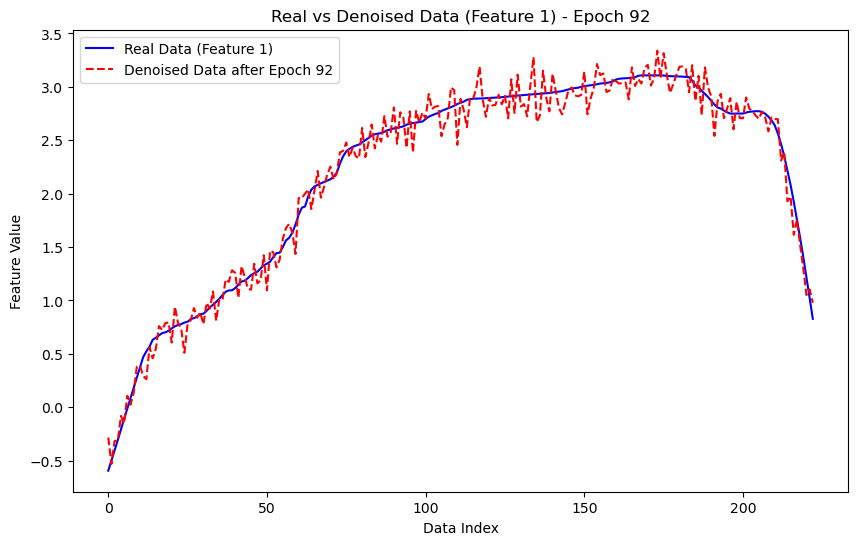

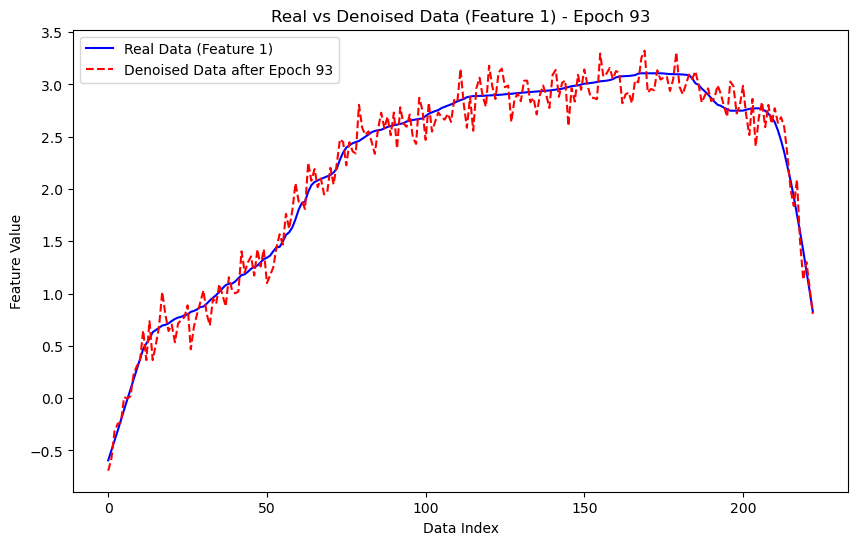

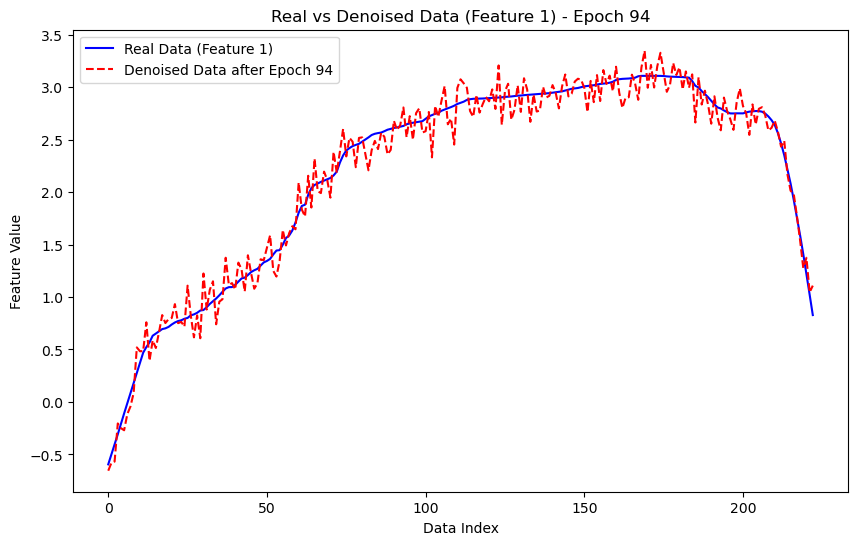

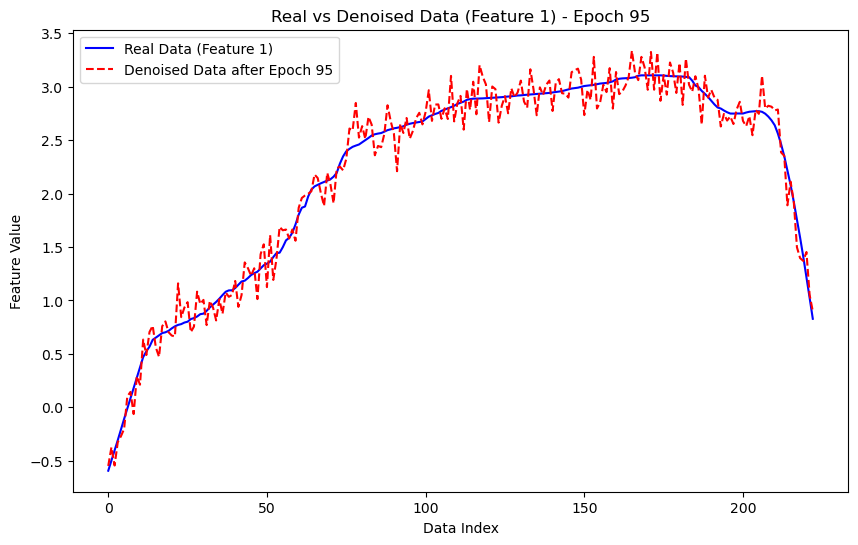

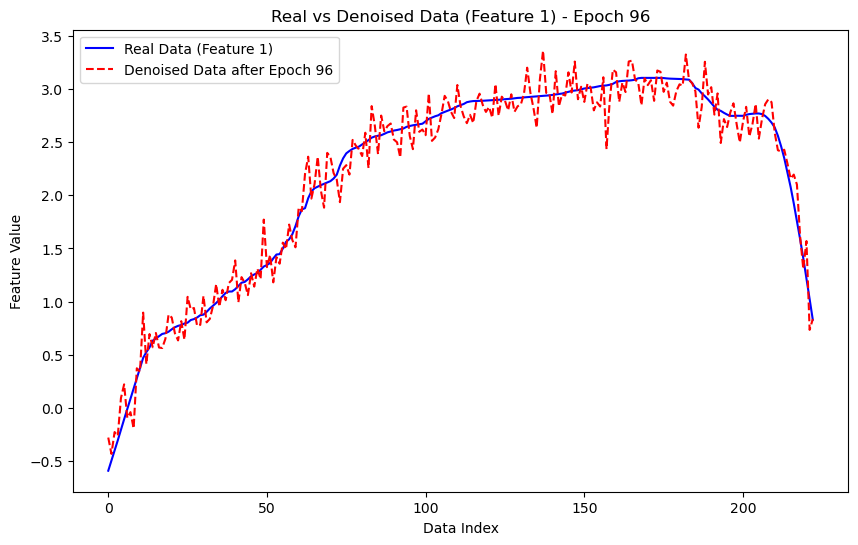

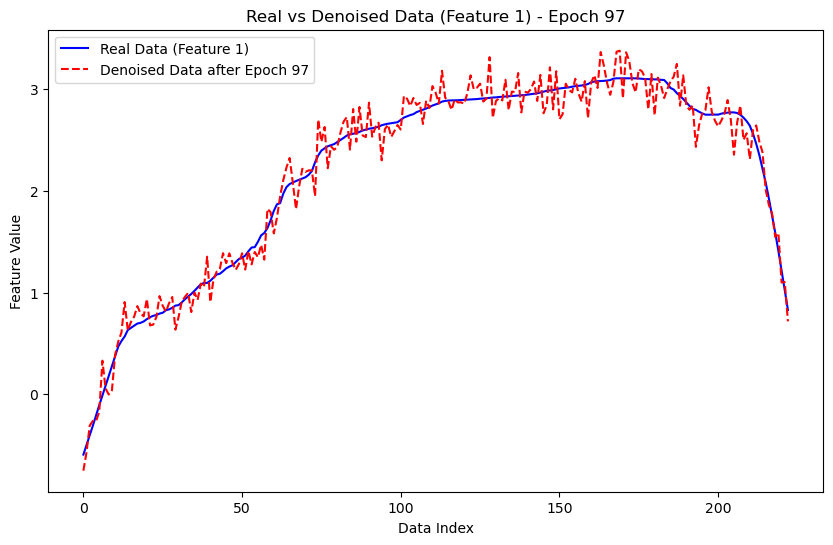

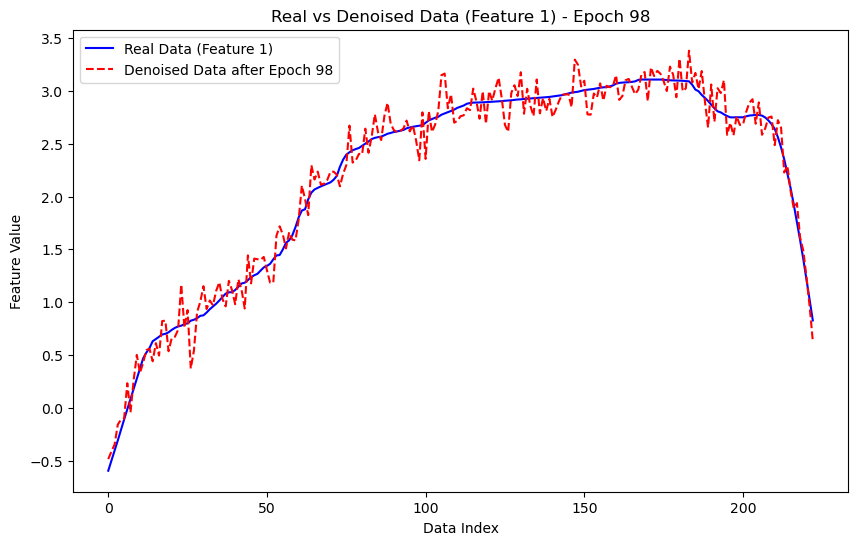

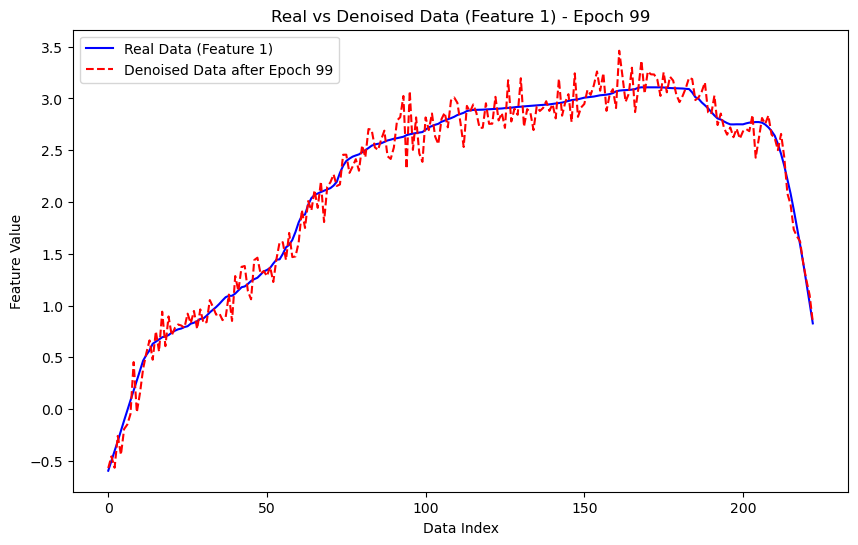

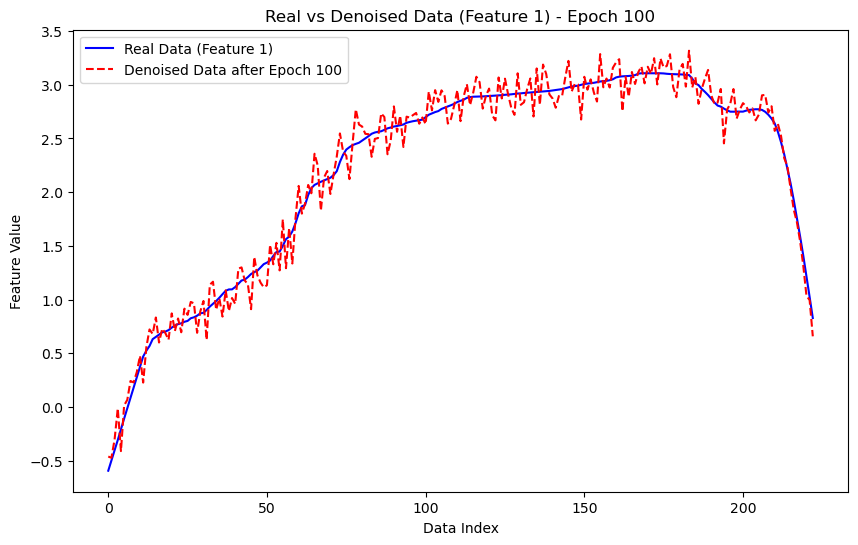

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, n_heads, n_layers, output_dim, dropout=0.1):
        super(TransformerEncoderModel, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=n_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        # Transformer expects [seq_len, batch_size, input_dim]
        transformer_output = self.transformer_encoder(src)
        output = self.fc_out(transformer_output[-1])  # Use the last time step's output
        return output

class DiffusionProcess:
    def __init__(self, steps, beta_start, beta_end):
        self.steps = steps
        self.beta = torch.linspace(beta_start, beta_end, steps).to(device)
    
    def add_noise(self, data, step):
        noise = torch.randn_like(data).to(device)
        noisy_data = data * torch.sqrt(1 - self.beta[step]) + noise * torch.sqrt(self.beta[step])
        return noisy_data

    def denoise(self, model, noisy_data, step):
        pred_noise = model(noisy_data)
        return noisy_data - pred_noise

# Initialize your data and model
data = torch.from_numpy(df).float().to(device)  # Move data to GPU
input_dim = 10
n_heads = 2
n_layers = 8
output_dim = 10
learning_rate = 1e-4
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02

# Initialize model, optimizer, and diffusion process
model = TransformerEncoderModel(input_dim, n_heads, n_layers, output_dim).to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
diffusion = DiffusionProcess(num_steps, beta_start, beta_end)

# Store predictions for visualization
predictions = []

# Example training loop
epochs = 100  # Number of epochs
for epoch in range(epochs):
    for step in range(diffusion.steps):
        noisy_data = diffusion.add_noise(data, step)

        optimizer.zero_grad()
        denoised_data = diffusion.denoise(model, noisy_data, step)

        # Define loss for regression (on GPU)
        loss = nn.MSELoss()(denoised_data, data)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Store denoised data after each epoch for visualization
    with torch.no_grad():
        final_denoised = diffusion.denoise(model, noisy_data, diffusion.steps - 1)  # Get final step prediction
        predictions.append(final_denoised.cpu())  # Move predictions to CPU for visualization

# Convert data to numpy for plotting
real_data_np = data.cpu().detach().numpy()  # Move data to CPU for plotting
predicted_data_np = [pred.cpu().detach().numpy() for pred in predictions]  # Convert to CPU and numpy for plotting

# Visualization
for i in range(epochs):
    plt.figure(figsize=(10, 6))
    
    # Plot original data (first feature)
    plt.plot(sorted_wavelengths, real_data_np[:, 0], label='Real Data (Feature 1)', color='blue')

    # Plot denoised data (first feature)
    plt.plot(sorted_wavelengths, predicted_data_np[i][:, 0], label=f'Denoised Data after Epoch {i+1}', linestyle='--', color='red')

    plt.xlabel('Data Index')
    plt.ylabel('Feature Value')
    plt.title(f'Real vs Denoised Data (Feature 1) - Epoch {i+1}')
    plt.legend()
    plt.show()


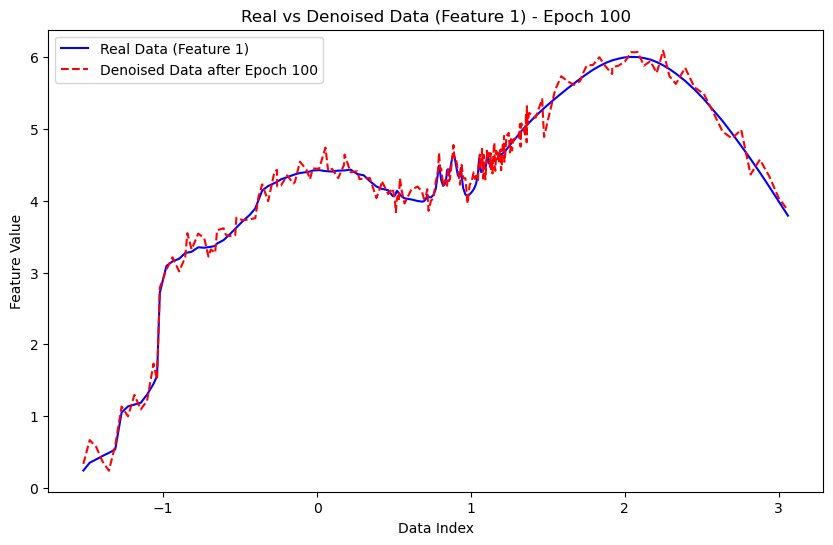

In [24]:
with torch.no_grad():
        final_denoised = diffusion.denoise(model, noisy_data, diffusion.steps - 1)  # Get final step prediction
        predictions.append(final_denoised.cpu())  # Move predictions to CPU for visualization

# Convert data to numpy for plotting
real_data_np = data.cpu().detach().numpy()  # Move data to CPU for plotting
predicted_data_np = [pred.cpu().detach().numpy() for pred in predictions]  # Convert to CPU and numpy for plotting

# Visualization
# for i in range(epochs):
plt.figure(figsize=(10, 6))

# Plot original data (first feature)
plt.plot(sorted_wavelengths, real_data_np[:, 2], label='Real Data (Feature 1)', color='blue')

# Plot denoised data (first feature)
plt.plot(sorted_wavelengths, predicted_data_np[1][:, 2], label=f'Denoised Data after Epoch {i+1}', linestyle='--', color='red')

plt.xlabel('Data Index')
plt.ylabel('Feature Value')
plt.title(f'Real vs Denoised Data (Feature 1) - Epoch {i+1}')
plt.legend()
plt.show()

In [25]:
final_denoised.shape

torch.Size([223, 10])

In [16]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.DataFrame(df) 

# Separate the wavelengths and flux values
wavelengths = sorted_wavelengths
flux_values = df

# Normalize the flux values
# scaler = MinMaxScaler()
# flux_values_normalized = scaler.fit_transform(flux_values)

# Convert to PyTorch tensors
flux_tensor = torch.tensor(flux_values, dtype=torch.float32)

print("Data loaded and preprocessed.")
flux_tensor.shape

Data loaded and preprocessed.


torch.Size([223, 10])

In [17]:
import torch.nn as nn

class TransformerGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(TransformerGenerator, self).__init__()
        self.embedding = nn.Linear(latent_dim, 128)  # Embedding layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=8), num_layers=16)
        self.fc = nn.Linear(128, output_dim)

    def forward(self, z):
        z = self.embedding(z).unsqueeze(1)  # Add sequence dimension
        z = self.transformer_encoder(z)
        return self.fc(z.squeeze(1))  # Remove sequence dimension

class TransformerDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(TransformerDiscriminator, self).__init__()
        self.embedding = nn.Linear(input_dim, 128)  # Embedding layer
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=128, nhead=8), num_layers=3)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add sequence dimension
        x = self.transformer_decoder(x, x)  # Use the same input as target
        return torch.sigmoid(self.fc(x.squeeze(1)))  # Remove sequence dimension

# Define dimensions
input_dim = flux_tensor.shape[1]  # Number of flux columns
latent_dim = 10  # Dimension of the random noise

# Instantiate the models
generator = TransformerGenerator(latent_dim, input_dim).to(device)
discriminator = TransformerDiscriminator(input_dim).to(device)

print("Generator and Discriminator defined.")



Generator and Discriminator defined.


c:\Users\vasil\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
from tqdm import tqdm

  0%|          | 1/1000 [00:00<15:15,  1.09it/s]

Epoch [0/1000], Loss D: 0.0506, Loss G: 0.0559


 10%|█         | 101/1000 [01:25<11:56,  1.26it/s]

Epoch [100/1000], Loss D: 0.0000, Loss G: 0.0009


 20%|██        | 201/1000 [02:50<12:04,  1.10it/s]

Epoch [200/1000], Loss D: 0.0000, Loss G: 0.0005


 30%|███       | 301/1000 [04:15<11:04,  1.05it/s]

Epoch [300/1000], Loss D: 0.0000, Loss G: 0.0003


 40%|████      | 401/1000 [05:41<08:02,  1.24it/s]

Epoch [400/1000], Loss D: 0.0000, Loss G: 0.0002


 50%|█████     | 501/1000 [07:05<06:52,  1.21it/s]

Epoch [500/1000], Loss D: 0.0000, Loss G: 0.0002


 60%|██████    | 601/1000 [08:29<05:48,  1.14it/s]

Epoch [600/1000], Loss D: 0.0000, Loss G: 0.0001


 70%|███████   | 701/1000 [09:52<03:50,  1.30it/s]

Epoch [700/1000], Loss D: 0.0000, Loss G: 0.0001


 80%|████████  | 801/1000 [11:16<02:35,  1.28it/s]

Epoch [800/1000], Loss D: 0.0000, Loss G: 0.0001


 90%|█████████ | 901/1000 [12:40<01:34,  1.04it/s]

Epoch [900/1000], Loss D: 0.0000, Loss G: 0.0001


100%|██████████| 1000/1000 [14:03<00:00,  1.19it/s]


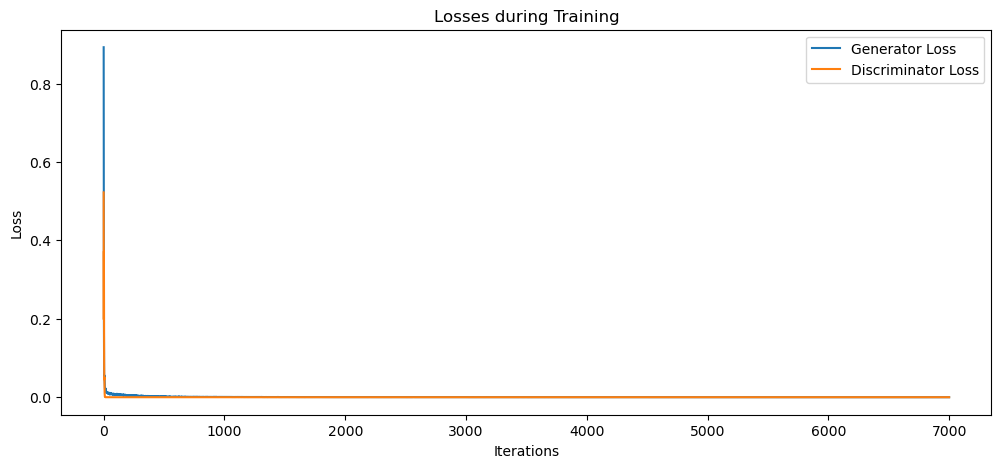

In [19]:
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 10000
batch_size = 32
learning_rate = 0.0002

# Loss functions and optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Lists to store losses
losses_G = []
losses_D = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    for i in range(0, len(flux_tensor), batch_size):
        # Get real data
        real_data = flux_tensor[i:i + batch_size]
        batch_size_real = real_data.size(0)

        # Create labels
        real_labels = torch.ones(batch_size_real, 1).to(device)
        fake_labels = torch.zeros(batch_size_real, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(real_data.to(device)).to(device)
        loss_D_real = criterion(outputs, real_labels)

        # Generate fake data
        noise = torch.randn(batch_size_real, latent_dim).to(device)
        fake_data = generator(noise)
        outputs = discriminator(fake_data.detach())
        loss_D_fake = criterion(outputs, fake_labels)

        # Backpropagation for Discriminator
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_data).to(device)
        loss_G = criterion(outputs, real_labels)

        # Backpropagation for Generator
        loss_G.backward()
        optimizer_G.step()

        # Store losses
        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

# Visualization of losses
plt.figure(figsize=(12, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.title('Losses during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [20]:
# Visualize generated data
with torch.no_grad():
    noise = torch.randn(223, latent_dim).to(device)
    generated_data = generator(noise).cpu().numpy()

# Plot real vs generated data
plt.figure(figsize=(12, 5))
plt.plot(sorted_wavelengths,df[:223,0], label='Real Data', alpha=0.5)
plt.scatter(sorted_wavelengths,generated_data[:223,0], label='Generated Data', alpha=0.5)
plt.title('Real vs Generated Data')
plt.xlabel('Sample Index')
plt.ylabel('Flux')
plt.legend()
plt.show()